In [124]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [125]:
# Set data paths
IMAGE_PATH = 'images/HAM10000_images'  
LABELS_PATH = 'images/HAM10000_metadata.csv'   


In [126]:
# Load the labels from the metadata file
df = pd.read_csv(LABELS_PATH)
df

lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]

In [127]:
# Create a mapping of labels
label_mapping = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_mapping)

In [128]:
# Load and preprocess images
def load_images(df, image_path, image_size=(128, 128)):
    images = []
    labels = []
    for image_id in df['image_id']:
        img_path = os.path.join(image_path, f"{image_id}.jpg")
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if image is not found
        img = cv2.resize(img, image_size)
        images.append(img)
        labels.append(df.loc[df['image_id'] == image_id, 'label'].values[0])
    return np.array(images), np.array(labels)

In [129]:
# Load and split data
X, y = load_images(df, IMAGE_PATH)
X = X / 255.0  # Normalize images to [0,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# ------ YOLOv5 Model Implementation -------
class YOLOv5(nn.Module):
    def __init__(self):
        super(YOLOv5, self).__init__()
        
        # Define the architecture for YOLO-like model
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)  # Fully connected layer
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 7)  # Output 7 classes (for the HAM10000 dataset)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Pass through conv1 and pool
        x = self.pool(torch.relu(self.conv2(x)))  # Pass through conv2 and pool
        x = self.pool(torch.relu(self.conv3(x)))  # Pass through conv3 and pool
        
        # Flatten
        x = x.reshape(-1, 64 * 16 * 16)  # Adjust this based on input size (128x128 -> 16x16 after 3 pools)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# Initialize model, loss function, and optimizer
yolo_model = YOLOv5()
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(yolo_model.parameters(), lr=0.0005)

In [12]:
# Function to train the YOLOv5 model
def train_yolo_model(model, X_train, y_train, epochs=10, batch_size=32):
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            inputs = torch.tensor(X_train[i:i + batch_size]).permute(0, 3, 1, 2).float()  # Convert to tensor and permute dimensions for PyTorch
            labels = torch.tensor(y_train[i:i + batch_size]).long()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(X_train)}")

# Train the YOLO-like model
train_yolo_model(yolo_model, X_train, y_train)

Epoch 1, Loss: 0.031144905063550114
Epoch 2, Loss: 0.02695131206655288
Epoch 3, Loss: 0.025205468940276594
Epoch 4, Loss: 0.02367597910251489
Epoch 5, Loss: 0.022038868347139164
Epoch 6, Loss: 0.020909079527682325
Epoch 7, Loss: 0.01959055152926752
Epoch 8, Loss: 0.018314143260582887
Epoch 9, Loss: 0.016853440500873954
Epoch 10, Loss: 0.01552704432853686


In [13]:

# Function to predict classes using YOLOv5 model
def yolo_predict(model, X):
    predictions = []
    with torch.no_grad():
        for img in X:
            img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2).float()  # Add batch dimension and permute
            output = model(img_tensor)
            pred_class = torch.argmax(output, dim=1).item()  # Get the predicted class index
            predictions.append(pred_class)
    
    return np.array(predictions)

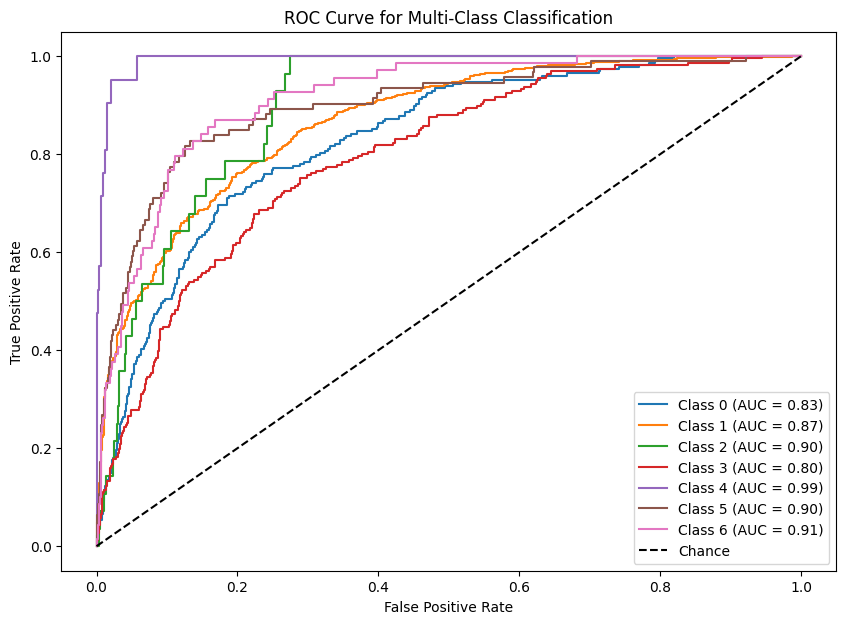

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding for multi-class ROC curve
y_test_one_hot = label_binarize(y_test, classes=np.arange(7))

# Get predicted probabilities from the model
def yolo_predict_proba(model, X):
    proba_predictions = []
    with torch.no_grad():
        for img in X:
            img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2).float()
            output = torch.softmax(model(img_tensor), dim=1)  # Apply softmax for probabilities
            proba_predictions.append(output.numpy()[0])  # Convert tensor to numpy
    return np.array(proba_predictions)

y_pred_proba = yolo_predict_proba(yolo_model, X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(7):  # 7 classes in HAM10000 dataset
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()


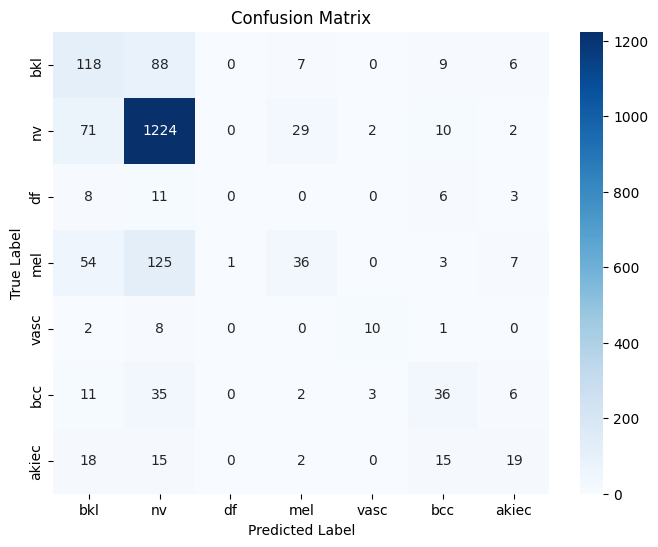

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
y_pred = yolo_predict(yolo_model, X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [16]:
torch.save(yolo_model.state_dict(), 'yolo_model.pth')  # Save YOLOv5 model state

In [17]:
# ------ CNN Model Implementation -------
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')  # 7 classes (based on the dataset)
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train CNN model
cnn_model = build_cnn_model((128, 128, 3))
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

C:\Users\yogee\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 189ms/step - accuracy: 0.6446 - loss: 1.2850 - val_accuracy: 0.6908 - val_loss: 0.9193
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 42s 186ms/step - accuracy: 0.6778 - loss: 0.9117 - val_accuracy: 0.6983 - val_loss: 0.8052
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 43s 192ms/step - accuracy: 0.6720 - loss: 0.8852 - val_accuracy: 0.7020 - val_loss: 0.7788
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - accuracy: 0.6789 - loss: 0.8478 - val_accuracy: 0.6970 - val_loss: 0.9169
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.6860 - loss: 0.8262 - val_accuracy: 0.7132 - val_loss: 0.7586
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - accuracy: 0.7046 - loss: 0.7957 - val_accuracy: 0.7107 - val_loss: 0.7464
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 43s 190ms/step - accuracy: 0.7154 - loss: 0.7720 - val_accuracy: 0.7307 - val_loss: 0.7488
Epoch 8/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.7183 - loss: 0

In [18]:
# CNN predictions
cnn_preds = np.argmax(cnn_model.predict(X_test), axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


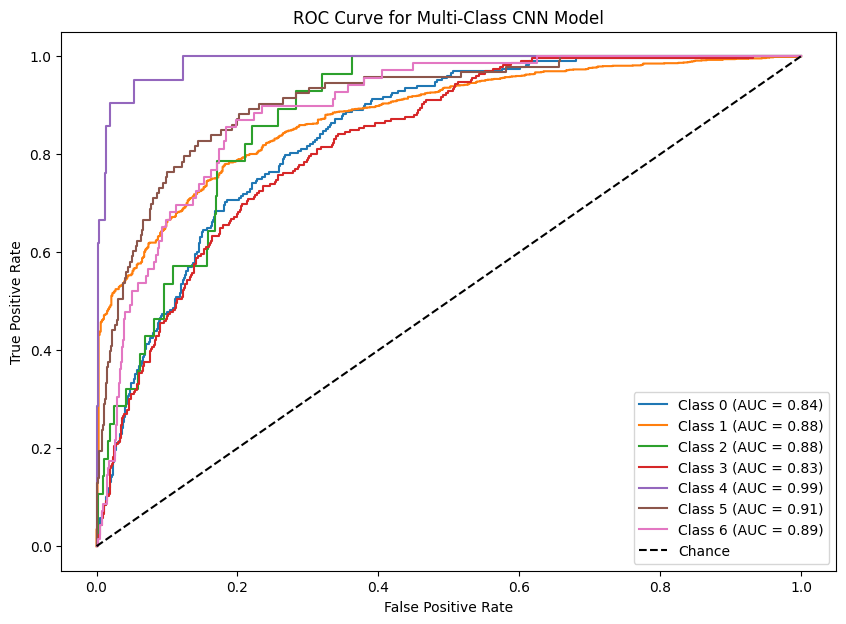

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding
y_test_one_hot = label_binarize(y_test, classes=np.arange(7))

# Get predicted probabilities from the CNN model
y_pred_proba = cnn_model.predict(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(7):  # 7 classes
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class CNN Model')
plt.legend()
plt.show()


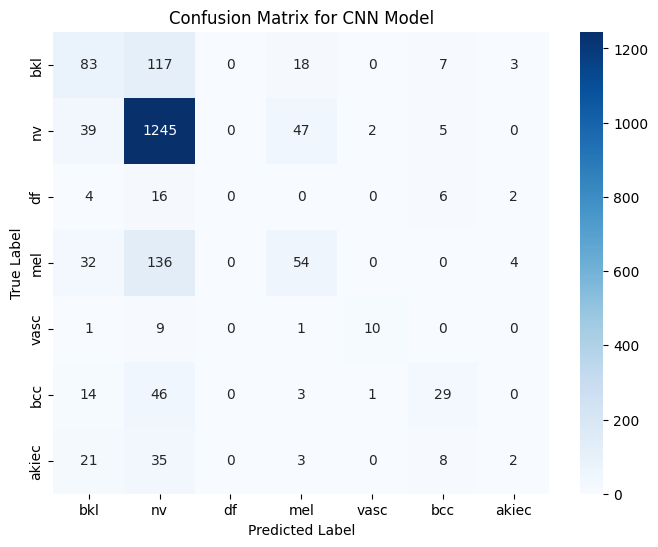

In [20]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, cnn_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for CNN Model")
plt.show()


In [21]:
cnn_model.save('cnn_model.h5')  # Save CNN model

In [22]:
# ------ Elastic Net Implementation -------
# Flatten the images for Elastic Net input
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train Elastic Net model
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X_train_flat, y_train)
elastic_net_preds = np.round(elastic_net_model.predict(X_test_flat))
elastic_net_preds = np.clip(elastic_net_preds, 0, 6)  # Ensure predictions are within valid class range


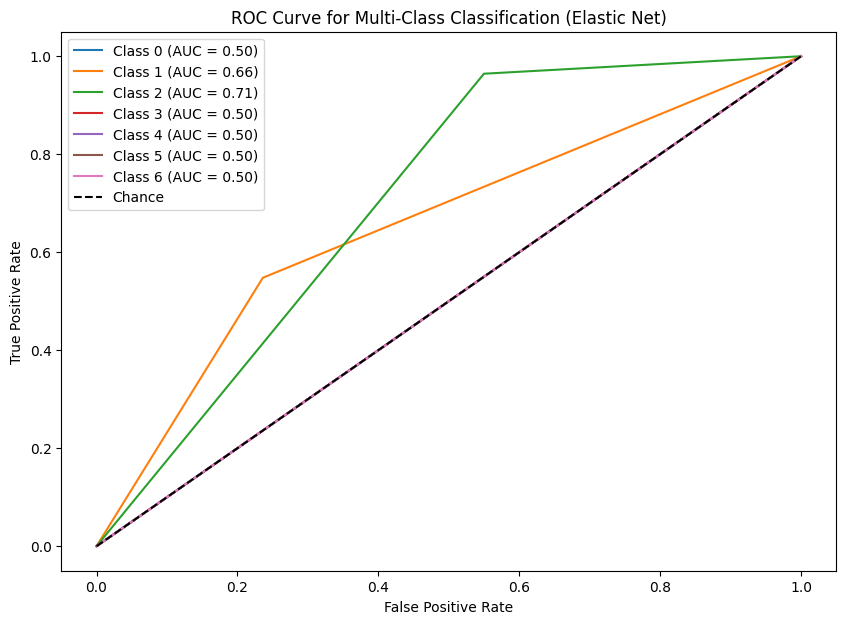

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert y_test to one-hot encoding for multi-class ROC curve
y_test_one_hot = label_binarize(y_test, classes=np.arange(7))

# Get predicted scores from Elastic Net (since it returns continuous values)
y_pred_scores = elastic_net_model.predict(X_test_flat)

# Binarize the predicted outputs
y_pred_one_hot = label_binarize(np.round(y_pred_scores), classes=np.arange(7))

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(7):  # 7 classes in HAM10000 dataset
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_one_hot[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal line (random guessing)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification (Elastic Net)')
plt.legend()
plt.show()


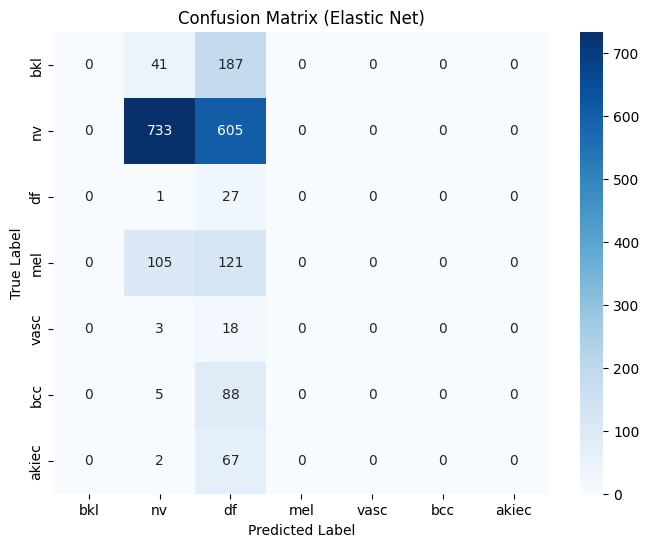

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, elastic_net_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Elastic Net)")
plt.show()


In [25]:
joblib.dump(elastic_net_model, 'elastic_net_model.joblib')  # Save Elastic Net model

['elastic_net_model.joblib']

In [26]:
# ------ Evaluation Metrics -------
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1

In [27]:
# Evaluate YOLOv5
yolo_preds = yolo_predict(yolo_model, X_test)
yolo_metrics = evaluate_model(y_test, yolo_preds, 'YOLOv5')

Results for YOLOv5:
Accuracy: 0.7204
Precision: 0.4662
Recall: 0.3900
F1-score: 0.4104


In [28]:
# Evaluate CNN
cnn_metrics = evaluate_model(y_test, cnn_preds, 'CNN')

Results for CNN:
Accuracy: 0.7104
Precision: 0.5873
Recall: 0.3358
F1-score: 0.3681


In [29]:
# Evaluate Elastic Net
elastic_net_metrics = evaluate_model(y_test, elastic_net_preds, 'Elastic Net')

Results for Elastic Net:
Accuracy: 0.3794
Precision: 0.8354
Recall: 0.2160
F1-score: 0.1008


In [30]:
%matplotlib inline

# ------ Plotting the Results -------
models = ['YOLOv5', 'CNN', 'Elastic Net']
accuracy = [yolo_metrics[0], cnn_metrics[0], elastic_net_metrics[0]]
precision = [yolo_metrics[1], cnn_metrics[1], elastic_net_metrics[1]]
recall = [yolo_metrics[2], cnn_metrics[2], elastic_net_metrics[2]]
f1 = [yolo_metrics[3], cnn_metrics[3], elastic_net_metrics[3]]


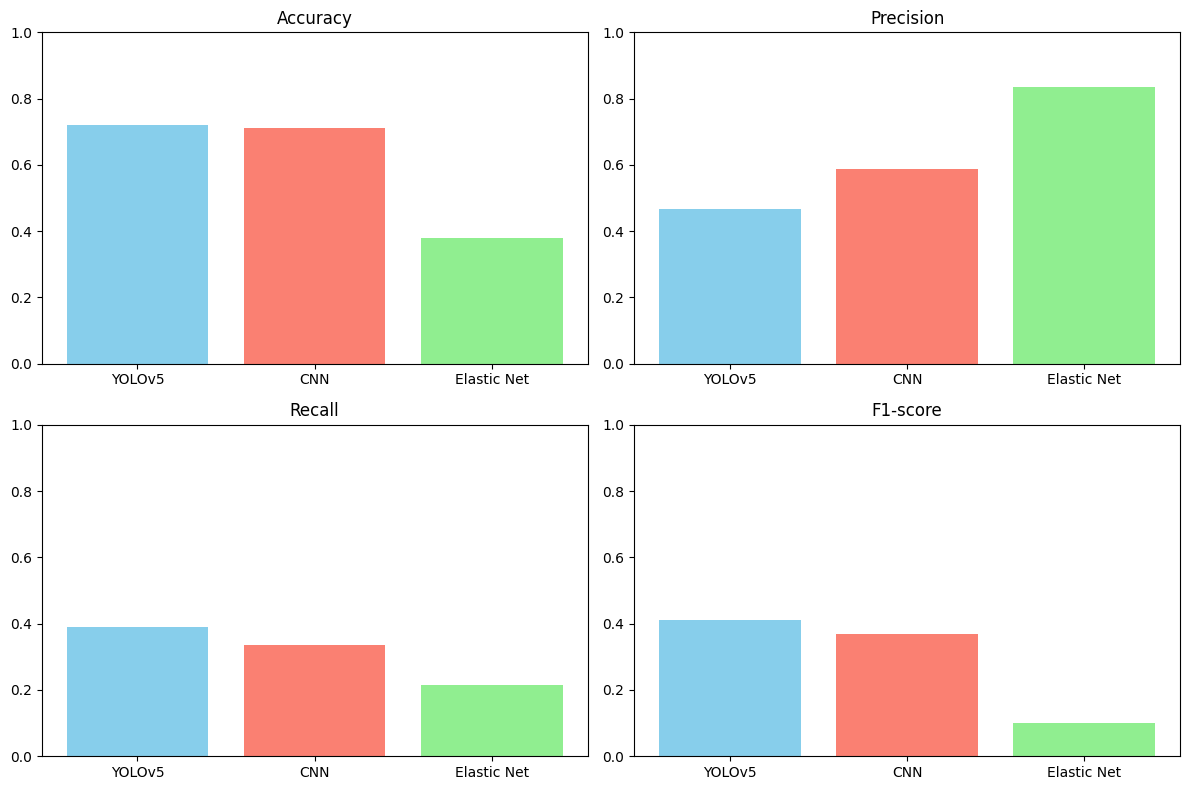

In [31]:
# Plot accuracy, precision, recall, F1-score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(models, metrics_values[i], color=['skyblue', 'salmon', 'lightgreen'])
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Detection

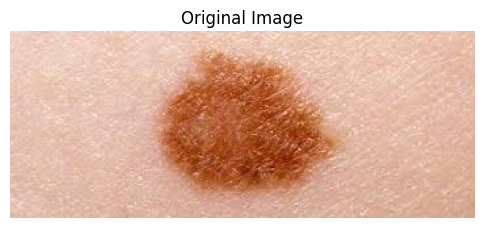

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class: 1


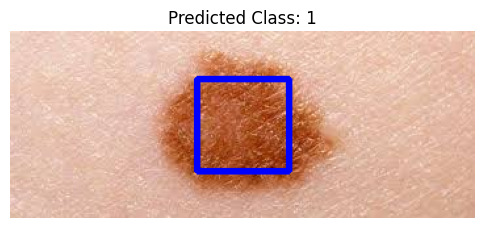

In [32]:
# ------ Image Detection with CNN ------
def predict_and_mark_image(image_path, cnn_model, input_size=(128, 128)):
    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return
    
    # Show the original image first
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Make a copy of the image for display
    img_copy = img.copy()

    # Resize the image to match CNN input
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img / 255.0, axis=0)  # Normalize and expand dimensions
    
    # Predict using the CNN model
    prediction = cnn_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class

    # Print the prediction result
    print(f"Predicted class: {predicted_class}")

    # Mark the center of the lesion with a red square (for demo purposes)
    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 2  # Adjust the square size as needed

    # Draw a red square around the center of the image
    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)  # (BGR format)

    # Show the image with the red square
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()


# Example usage: Pass the image path and CNN model
image_path = 'images/images.jpeg'  # Replace with the actual test image path
predict_and_mark_image(image_path, cnn_model)

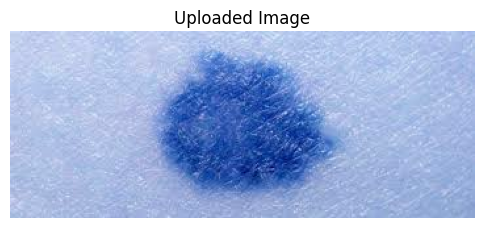

Predicted class: 1


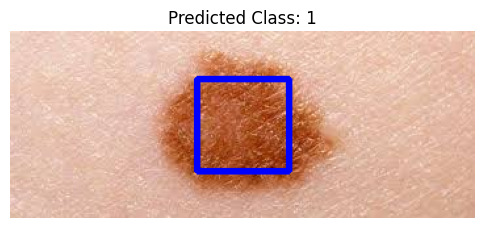

In [33]:
# ------ Image Detection with YOLOv5 ------
def predict_and_mark_image_yolo(image_path, model, input_size=(128, 128)):
    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return

    # Show the uploaded image before processing
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()
    
    # Make a copy of the image for display purposes
    img_copy = img.copy()

    # Resize the image to match YOLO-like model input
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img, axis=0)  # Expand dimensions for batch size
    img_array = torch.tensor(img_array.transpose(0, 3, 1, 2), dtype=torch.float32) / 255.0  # Convert to PyTorch tensor and normalize

    # Predict using the YOLOv5-like model
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        outputs = model(img_array)
        predicted_class = torch.argmax(outputs, dim=1).item()  # Get the predicted class index

    # Print the prediction result
    print(f"Predicted class: {predicted_class}")

    # Mark the center of the lesion with a red square (for demo purposes)
    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 2  # Adjust the square size as needed

    # Draw a red square around the center of the image
    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)  # (BGR format)

    # Show the image with the red square
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage: Pass the image path and YOLOv5-like model
image_path = 'images/images.jpeg'  # Replace with the actual test image path
predict_and_mark_image_yolo(image_path, yolo_model)  # Use your trained YOLOv5-like model


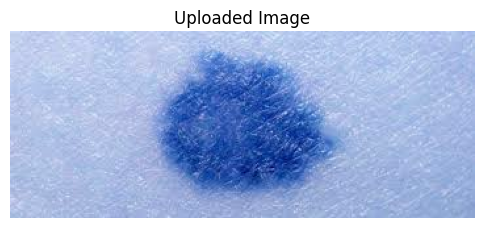

Predicted class: 6


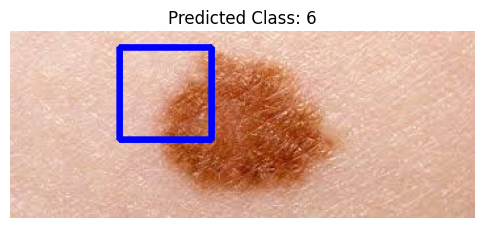

In [34]:
# ------ Image Detection with Elastic Net ------
def predict_and_mark_image_elastic_net(image_path, model, input_size=(128, 128)):
    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return

    # Show the uploaded image before processing
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Make a copy of the image for display purposes
    img_copy = img.copy()

    # Resize the image and flatten it for Elastic Net input
    resized_img = cv2.resize(img, input_size)
    img_flattened = resized_img.flatten()  # Flatten to 1D array

    # Predict using the Elastic Net model
    img_flattened = img_flattened.reshape(1, -1)  # Reshape to match Elastic Net input
    predicted_class = model.predict(img_flattened)
    predicted_class = np.clip(np.round(predicted_class), 0, 6).astype(int)[0]  # Ensure valid class

    # Print the prediction result
    print(f"Predicted class: {predicted_class}")

    # Mark the center of the lesion with a red square (for demo purposes)
    height, width, _ = img.shape
    center_x, center_y = width // 3, height // 3
    square_size = min(width, height) // 2  # Adjust the square size as needed

    # Draw a red square around the center of the image
    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)  # (BGR format)

    # Show the image with the red square
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage: Pass the image path and Elastic Net model
image_path = 'images/images.jpeg'  # Replace with the actual test image path
predict_and_mark_image_elastic_net(image_path, elastic_net_model)  # Use your trained Elastic Net model


YOLO_CNN HYBRID 

In [35]:
# ------ Hybrid YOLO-CNN Model Implementation -------
class HybridYOLOCNN(nn.Module):
    def __init__(self):
        super(HybridYOLOCNN, self).__init__()
        
        # YOLO-inspired layers for feature extraction
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # CNN-inspired fully connected layers for classification
        self.fc1 = nn.Linear(64 * 16 * 16, 512)  # Fully connected layer
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 7)  # Output 7 classes (for the HAM10000 dataset)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Pass through conv1 and pool
        x = self.pool(torch.relu(self.conv2(x)))  # Pass through conv2 and pool
        x = self.pool(torch.relu(self.conv3(x)))  # Pass through conv3 and pool
        
        # Flatten
        x = x.reshape(-1, 64 * 16 * 16)  # Adjust this based on input size (128x128 -> 16x16 after 3 pools)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
hybrid_model = HybridYOLOCNN()
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(hybrid_model.parameters(), lr=0.0005)

In [36]:
# Function to train the hybrid YOLO-CNN model
def train_hybrid_model(model, X_train, y_train, epochs=10, batch_size=32):
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            inputs = torch.tensor(X_train[i:i + batch_size]).permute(0, 3, 1, 2).float()  # Convert to tensor and permute dimensions for PyTorch
            labels = torch.tensor(y_train[i:i + batch_size]).long()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(X_train)}")

In [37]:
# Train the hybrid model
train_hybrid_model(hybrid_model, X_train, y_train)

# Function to predict classes using the hybrid YOLO-CNN model
def hybrid_predict(model, X):
    predictions = []
    with torch.no_grad():
        for img in X:
            img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2).float()  # Add batch dimension and permute
            output = model(img_tensor)
            pred_class = torch.argmax(output, dim=1).item()  # Get the predicted class index
            predictions.append(pred_class)
    
    return np.array(predictions)

Epoch 1, Loss: 0.030735813029188545
Epoch 2, Loss: 0.026041129396608097
Epoch 3, Loss: 0.024332843564685083
Epoch 4, Loss: 0.02284103583245056
Epoch 5, Loss: 0.02188343967251104
Epoch 6, Loss: 0.02053754983160178
Epoch 7, Loss: 0.019357920330923553
Epoch 8, Loss: 0.018195601246220675
Epoch 9, Loss: 0.016994841566055463
Epoch 10, Loss: 0.015393935992971576


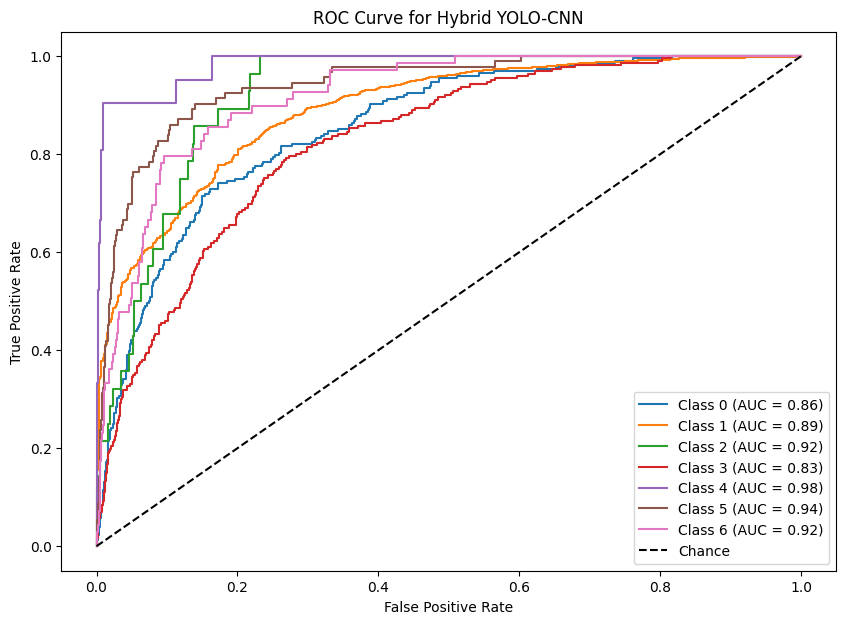

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding for multi-class ROC curve
y_test_one_hot = label_binarize(y_test, classes=np.arange(7))

# Get predicted probabilities from the model
def hybrid_predict_proba(model, X):
    proba_predictions = []
    with torch.no_grad():
        for img in X:
            img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2).float()
            output = torch.softmax(model(img_tensor), dim=1)  # Apply softmax for probabilities
            proba_predictions.append(output.numpy()[0])  # Convert tensor to numpy
    return np.array(proba_predictions)

y_pred_proba = hybrid_predict_proba(hybrid_model, X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(7):  # 7 classes in HAM10000 dataset
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hybrid YOLO-CNN')
plt.legend()
plt.show()


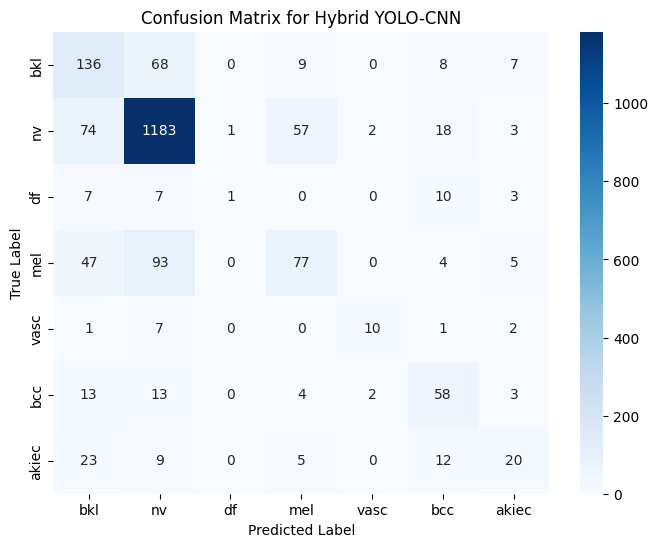

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
y_pred = hybrid_predict(hybrid_model, X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Hybrid YOLO-CNN")
plt.show()


In [40]:
torch.save(hybrid_model.state_dict(), 'hybrid_yolo_cnn_model.pth')

In [41]:
# Evaluate model function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1

In [42]:
# Evaluate Hybrid YOLO-CNN Model
hybrid_preds = hybrid_predict(hybrid_model, X_test)
hybrid_metrics = evaluate_model(y_test, hybrid_preds, 'Hybrid YOLO-CNN')

Results for Hybrid YOLO-CNN:
Accuracy: 0.7414
Precision: 0.5739
Recall: 0.4638
F1-score: 0.4794


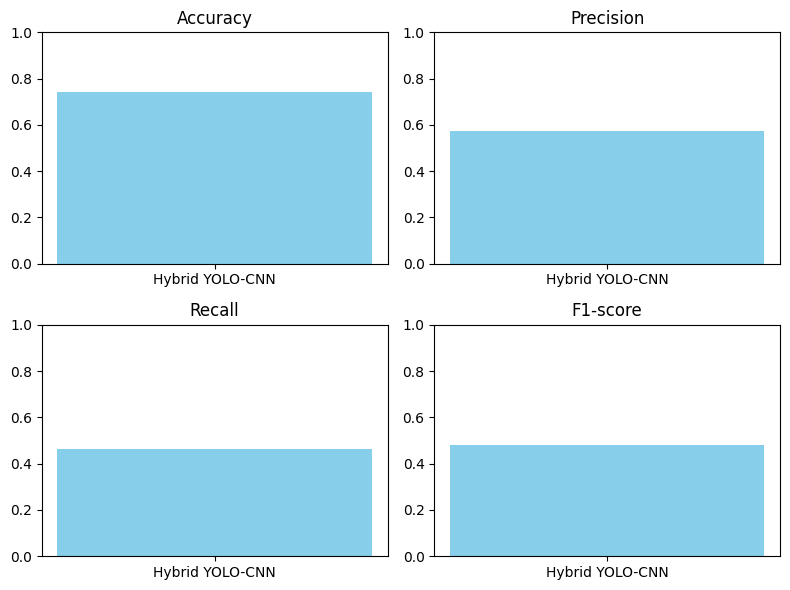

In [43]:
# Plot the results
models = ['Hybrid YOLO-CNN']
accuracy = [hybrid_metrics[0]]
precision = [hybrid_metrics[1]]
recall = [hybrid_metrics[2]]
f1 = [hybrid_metrics[3]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(models, metrics_values[i], color='skyblue')
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

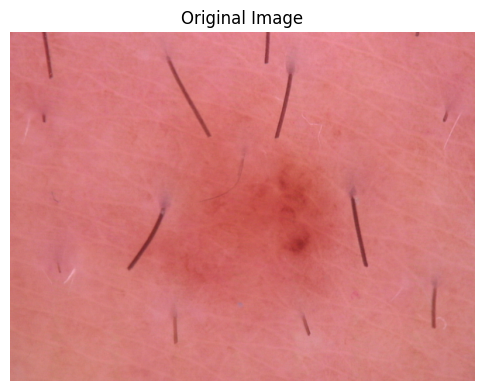

Predicted class: 1


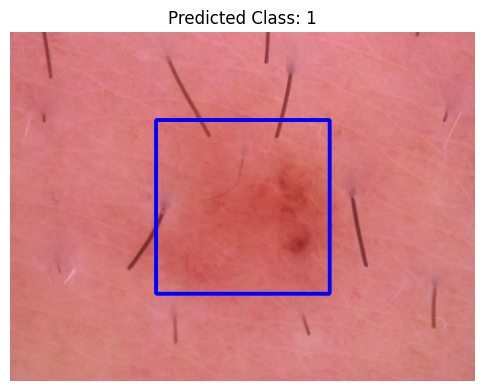

In [44]:
# Image detection function with the hybrid model
def predict_and_mark_image_hybrid(image_path, model, input_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    img_copy = img.copy()
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img, axis=0)
    img_tensor = torch.tensor(img_array.transpose(0, 3, 1, 2), dtype=torch.float32) / 255.0

    with torch.no_grad():
        outputs = model(img_tensor)
        predicted_class = torch.argmax(outputs, dim=1).item()

    print(f"Predicted class: {predicted_class}")

    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 2

    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage: Pass the image path and hybrid model
image_path = 'images/HAM10000_images/ISIC_0024321.jpg'  # Replace with the actual test image path
predict_and_mark_image_hybrid(image_path, hybrid_model)

R-CNN Implementation

In [45]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

In [46]:
# Define the RCNN architecture
def rcnn_model(input_shape=(128, 128, 3), num_classes=7):
    input_layer = layers.Input(shape=input_shape)

    # Pretrained backbone model (ResNet50) for feature extraction
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the backbone

    # Apply ROI pooling and region-based CNN layers here
    x = base_model(input_layer)
    x = layers.GlobalAveragePooling2D()(x)  # Pooling to reduce spatial dimensions

    # Fully connected layers
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [47]:
# Initialize and train the model
model = rcnn_model(input_shape=(128, 128, 3), num_classes=len(label_mapping))
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,693,063 (98.01 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [48]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 185s 714ms/step - accuracy: 0.6492 - loss: 1.2392 - val_accuracy: 0.6680 - val_loss: 1.1288
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 179s 712ms/step - accuracy: 0.6673 - loss: 1.1603 - val_accuracy: 0.6680 - val_loss: 1.1271
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 179s 712ms/step - accuracy: 0.6717 - loss: 1.1485 - val_accuracy: 0.6680 - val_loss: 1.1224
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 179s 713ms/step - accuracy: 0.6785 - loss: 1.1209 - val_accuracy: 0.6680 - val_loss: 1.1239
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 186s 741ms/step - accuracy: 0.6733 - loss: 1.1370 - val_accuracy: 0.6680 - val_loss: 1.1191
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 179s 712ms/step - accuracy: 0.6702 - loss: 1.1360 - val_accuracy: 0.6680 - val_loss: 1.1051
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 179s 713ms/step - accuracy: 0.6737 - loss: 1.1131 - val_accuracy: 0.6680 - val_loss: 1.1004
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 180s 716ms/step - accuracy: 0.6662 -

In [49]:
# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 518ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 549ms/step


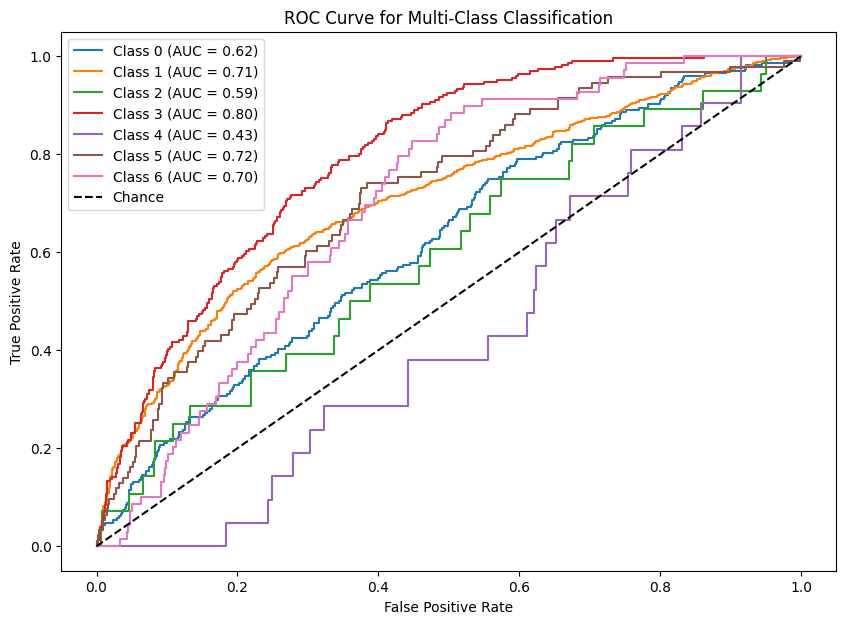

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding for multi-class ROC curve
y_test_one_hot = label_binarize(y_test, classes=np.arange(len(label_mapping)))

# Get predicted probabilities from the trained model
y_pred_proba = model.predict(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(len(label_mapping)):  # Iterate through each class
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step


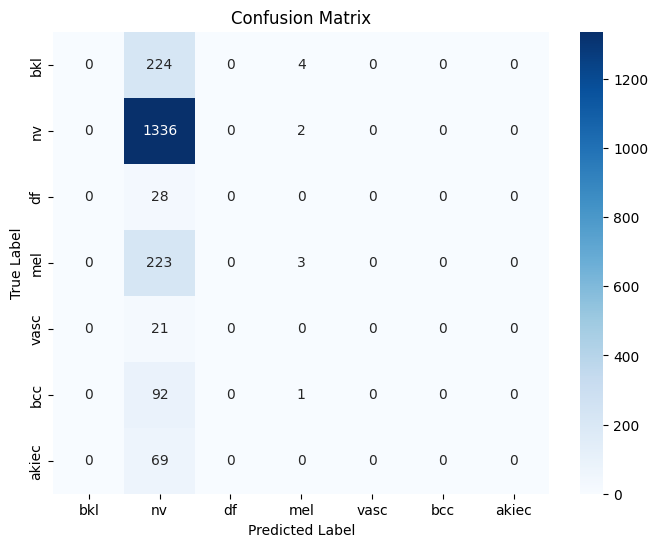

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted class labels
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [52]:
# ------ Evaluation Metrics -------
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Call the evaluation function for the model
rcnn_metrics=evaluate_model(y_test, y_pred, model_name="RCNN Skin Lesion Model")

# Save the model
model.save('rcnn_skin_lesion_model.h5')

Results for RCNN Skin Lesion Model:
Accuracy: 0.6685
Precision: 0.8529
Recall: 0.1445
F1-score: 0.1182


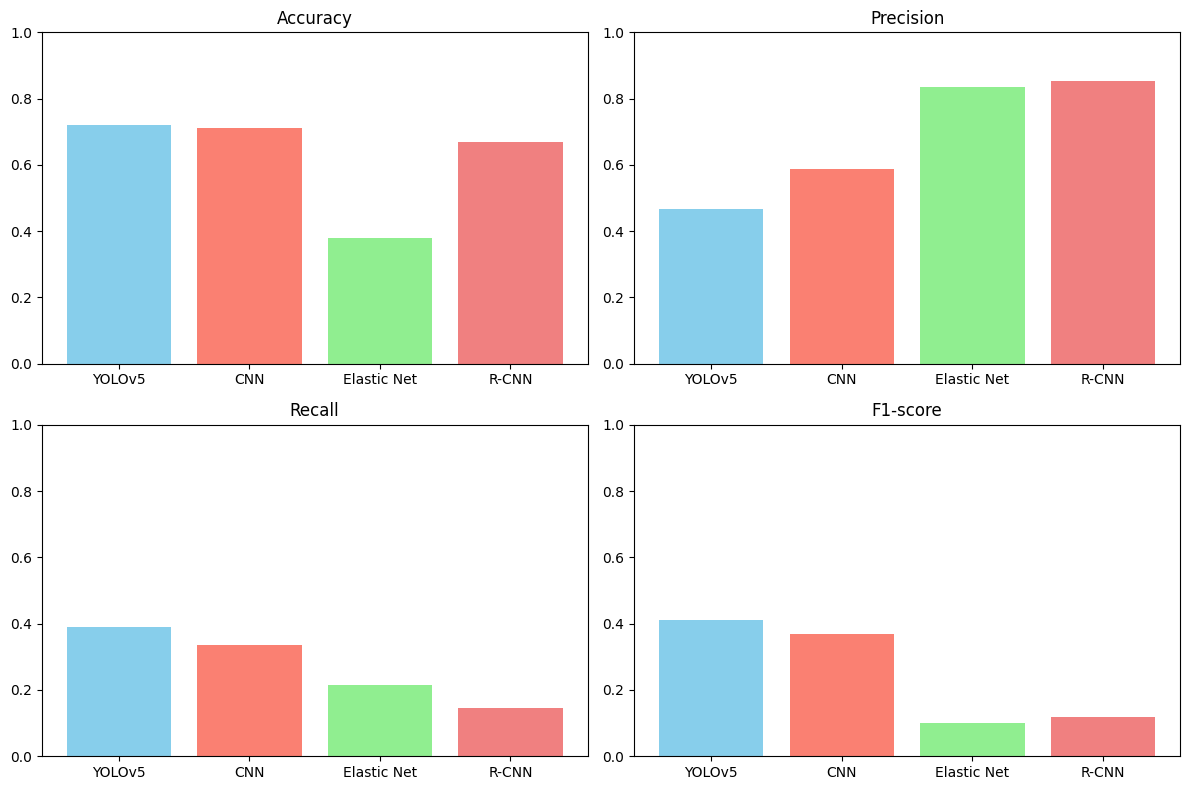

In [53]:
# ------ Plotting Results ------
models = ['YOLOv5', 'CNN', 'Elastic Net', 'R-CNN']
accuracy = [yolo_metrics[0], cnn_metrics[0], elastic_net_metrics[0], rcnn_metrics[0]]
precision = [yolo_metrics[1], cnn_metrics[1], elastic_net_metrics[1], rcnn_metrics[1]]
recall = [yolo_metrics[2], cnn_metrics[2], elastic_net_metrics[2], rcnn_metrics[2]]
f1 = [yolo_metrics[3], cnn_metrics[3], elastic_net_metrics[3], rcnn_metrics[3]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

# Create subplots for each metric
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(models, metrics_values[i], color=['skyblue', 'salmon', 'lightgreen', 'lightcoral'])
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

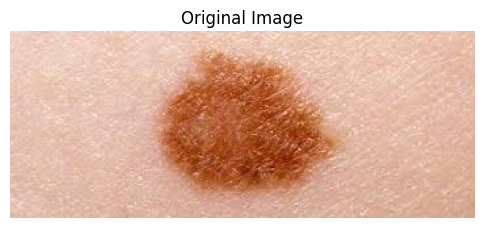

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: 1


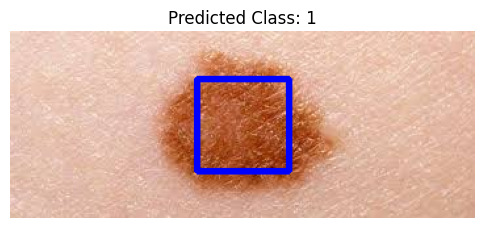

In [54]:
# ------ Image Detection with RCNN ------
from tensorflow.keras.models import load_model

# Define the function to predict and mark the image (as you already have it)
def predict_and_mark_image(image_path, rcnn_model, input_size=(128, 128)):
    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return
    
    # Show the original image first
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Make a copy of the image for display
    img_copy = img.copy()

    # Resize the image to match RCNN input
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img / 255.0, axis=0)  # Normalize and expand dimensions

    # Predict using the RCNN model
    prediction = rcnn_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class

    # Print the prediction result
    print(f"Predicted class: {predicted_class}")

    # Mark the center of the lesion with a red square (for demo purposes)
    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 2  # Adjust the square size as needed

    # Draw a red square around the center of the image
    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)  # (BGR format)

    # Show the image with the red square
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()


rcnn_model = load_model('rcnn_skin_lesion_model.h5')  



image_path = 'images/images.jpeg' 
predict_and_mark_image(image_path, rcnn_model)

SSD (Single Shot MultiBox Detector)

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [56]:
# Define the SSD model architecture
def build_ssd_model(input_shape=(128, 128, 3), num_classes=7):
    # Base model (MobileNetV2 as a backbone)
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze base model layers
    
    # Adding custom layers on top of the base model
    x = base_model.output
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [57]:
# Initialize and compile the model
model = build_ssd_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 8,683,079 (33.12 MB)

 Trainable params: 6,425,095 (24.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [58]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 107s 406ms/step - accuracy: 0.6319 - loss: 1.2692 - val_accuracy: 0.6965 - val_loss: 0.8512
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 503ms/step - accuracy: 0.7257 - loss: 0.8080 - val_accuracy: 0.7229 - val_loss: 0.7888
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 511ms/step - accuracy: 0.7423 - loss: 0.7239 - val_accuracy: 0.7244 - val_loss: 0.7517
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 438ms/step - accuracy: 0.7716 - loss: 0.6337 - val_accuracy: 0.7394 - val_loss: 0.7414
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 116s 464ms/step - accuracy: 0.8038 - loss: 0.5602 - val_accuracy: 0.7454 - val_loss: 0.7472
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 109s 436ms/step - accuracy: 0.8267 - loss: 0.4899 - val_accuracy: 0.7524 - val_loss: 0.7478
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 114s 456ms/step - accuracy: 0.8386 - loss: 0.4535 - val_accuracy: 0.7554 - val_loss: 0.7207
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 113s 452ms/step - accuracy: 0.8646 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step


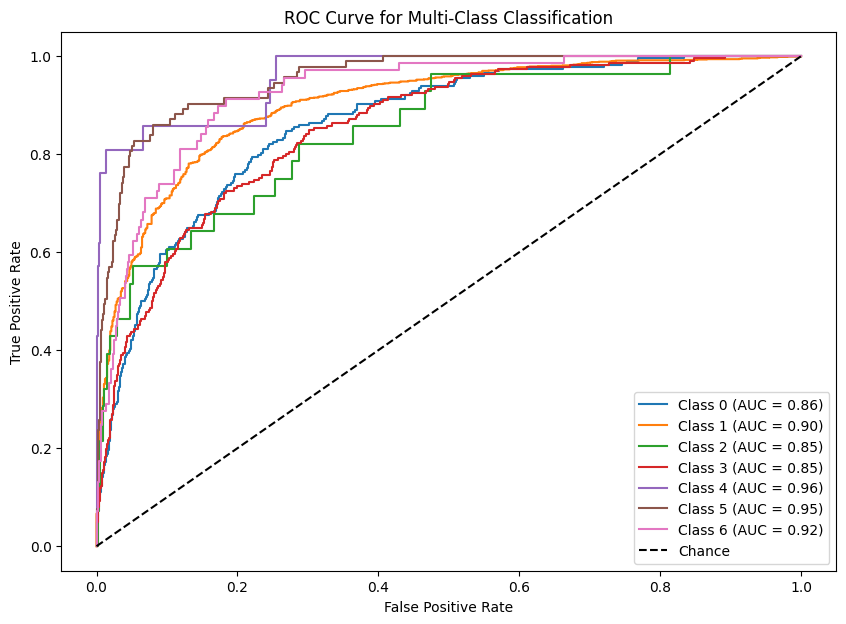

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert y_test to one-hot encoding
y_test_one_hot = label_binarize(y_test, classes=np.arange(7))

# Get predicted probabilities from the model
y_pred_proba = model.predict(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(7):  # 7 classes in the dataset
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step


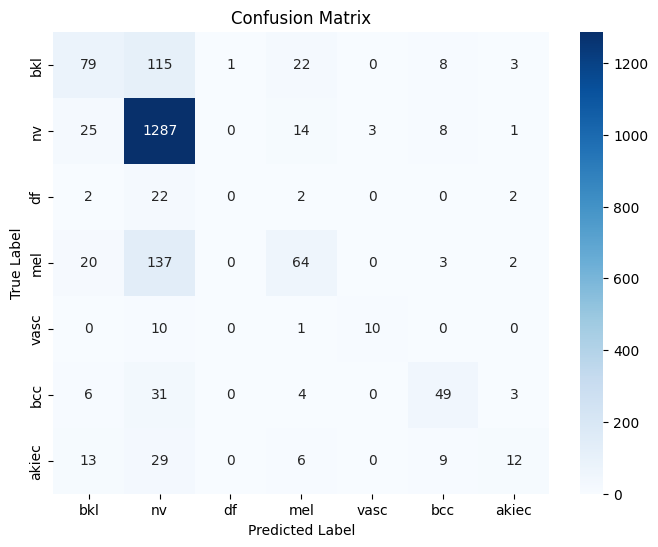

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted class labels
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [61]:
# Save the trained model
model.save('ssd_skin_lesion_detection_model.h5')
print("Model saved as 'ssd_skin_lesion_detection_model.h5'.")

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Predict on test images
predictions = model.predict(X_test)

# Convert predictions to label format
y_pred = np.argmax(predictions, axis=1)

Model saved as 'ssd_skin_lesion_detection_model.h5'.
63/63 - 13s - 206ms/step - accuracy: 0.7494 - loss: 0.8704
Test accuracy: 0.7494
Test loss: 0.8704
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step


In [62]:
# ------ Evaluation Metrics -------
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Evaluate the model
ssd_metrics=evaluate_model(y_test, y_pred, 'SSD Skin Lesion Detection Model')

Results for SSD Skin Lesion Detection Model:
Accuracy: 0.7494
Precision: 0.5468
Recall: 0.3955
F1-score: 0.4420


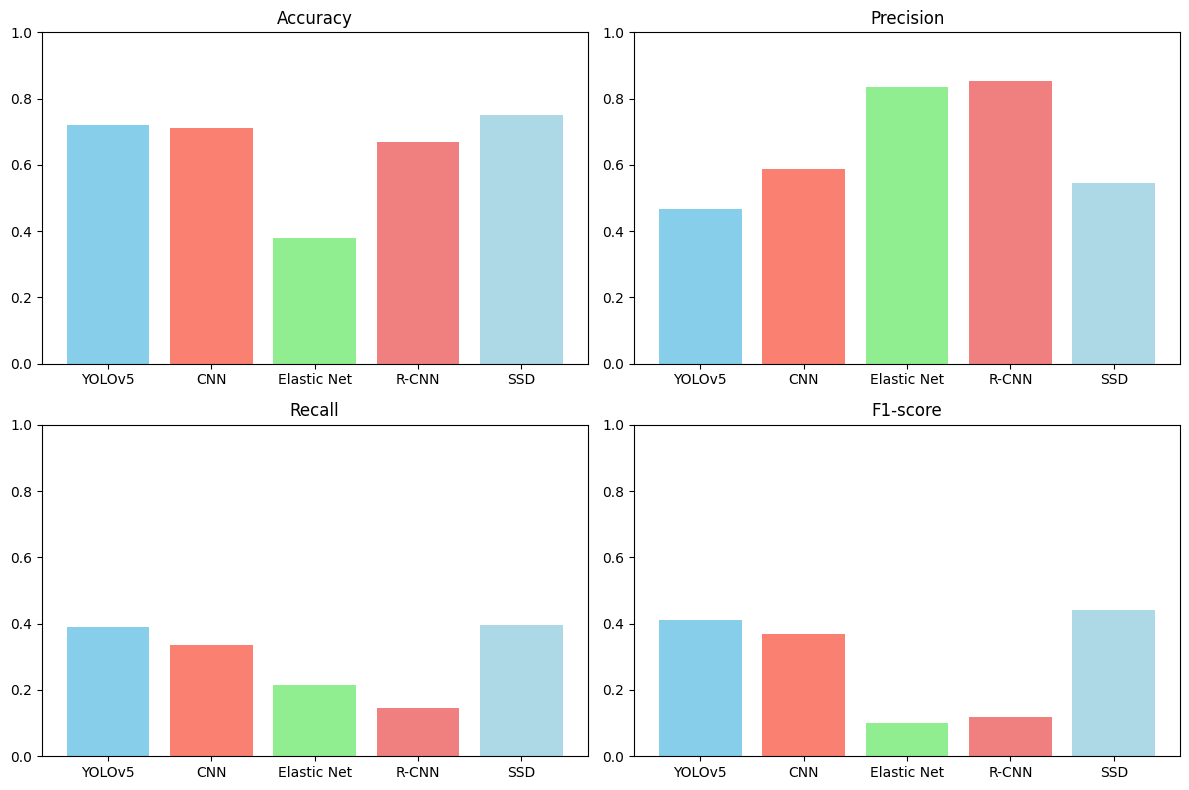

In [63]:
models = ['YOLOv5', 'CNN', 'Elastic Net', 'R-CNN', 'SSD']
accuracy = [yolo_metrics[0], cnn_metrics[0], elastic_net_metrics[0], rcnn_metrics[0], ssd_metrics[0]]
precision = [yolo_metrics[1], cnn_metrics[1], elastic_net_metrics[1], rcnn_metrics[1], ssd_metrics[1]]
recall = [yolo_metrics[2], cnn_metrics[2], elastic_net_metrics[2], rcnn_metrics[2], ssd_metrics[2]]
f1 = [yolo_metrics[3], cnn_metrics[3], elastic_net_metrics[3], rcnn_metrics[3], ssd_metrics[3]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

# Create subplots for each metric
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(models, metrics_values[i], color=['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'lightblue'])
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

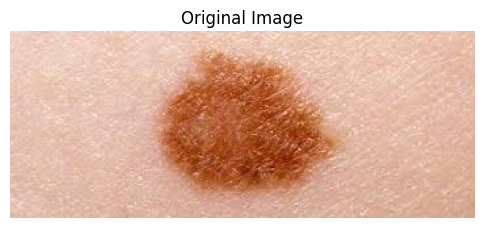

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: 1


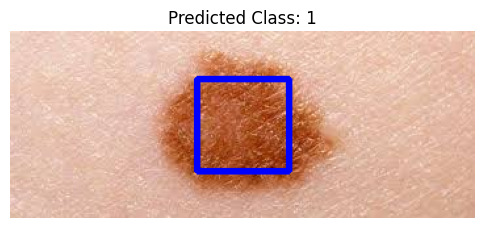

In [64]:
# Function to predict and mark image for SSD model
def predict_and_mark_image(image_path, ssd_model, input_size=(128, 128)):
    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return
    
    # Show the original image first
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Make a copy of the image for display
    img_copy = img.copy()

    # Resize the image to match SSD model input size
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img / 255.0, axis=0)  # Normalize and expand dimensions

    # Predict using the SSD model
    prediction = ssd_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class

    # Print the prediction result
    print(f"Predicted class: {predicted_class}")

    # Mark the center of the image with a red square (for demo purposes)
    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 2  # Adjust the square size as needed

    # Draw a red square around the center of the image
    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)  # (BGR format)

    # Show the image with the red square
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage: Pass the image path and SSD model
image_path = 'images/images.jpeg'  # Replace with the actual test image path
ssd_model = tf.keras.models.load_model('ssd_skin_lesion_detection_model.h5')  # Load the SSD model
predict_and_mark_image(image_path, ssd_model)

RCNN_SSD Hybrid

In [130]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 

In [131]:
# Define the Hybrid R-CNN + SSD model
def hybrid_rcnn_ssd_model(input_shape=(128, 128, 3), num_classes=7):
    # Feature extraction using ResNet50 (R-CNN style feature extractor)
    input_layer = layers.Input(shape=input_shape)
    
    # Backbone Model for feature extraction
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_resnet.trainable = False  # Freeze the backbone

    # Apply R-CNN style region proposal layers
    x = base_model_resnet(input_layer)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)  # Fully connected layer
    x = layers.Dropout(0.5)(x)
    region_proposal_layer = layers.Dense(num_classes, activation='softmax')(x)  # Object classification

    # SSD style detection (MobileNetV2 backbone)
    base_model_mobilenet = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model_mobilenet.trainable = False  # Freeze backbone layers
    
    # SSD-style object detection head (convolutional layers)
    y = base_model_mobilenet(input_layer)
    y = Conv2D(512, (3, 3), activation='relu', padding='same')(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Flatten()(y)
    y = Dense(256, activation='relu')(y)
    y = Dropout(0.5)(y)
    ssd_output_layer = Dense(num_classes, activation='softmax')(y)  # SSD output

    # Combine both models (R-CNN and SSD) for hybrid output
    final_output = layers.Average()([region_proposal_layer, ssd_output_layer])  # Simple averaging of outputs
    
    # Compile the final hybrid model
    model = models.Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize and train the hybrid model
model = hybrid_rcnn_ssd_model(input_shape=(128, 128, 3), num_classes=len(label_mapping))
model.summary()


Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ mobilenetv2_1.00_128          │ (None, 4, 4, 1280)        │       2,257,984 │ input_layer_23[0][0]       │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 4, 4, 512)         │       5,898,752 │ mobilenetv2_1.00_128[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet50 (Functional)         │ (None, 4, 4, 2048)        │      23,587,712 │ input_layer_23[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_24              │ (None, 2, 2, 512)         │               0 │ conv2d_24[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_4    │ (None, 2048)              │               0 │ resnet50[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_12 (Flatten)          │ (None, 2048)              │               0 │ max_pooling2d_24[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_34 (Dense)              │ (None, 1024)              │       2,098,176 │ global_average_pooling2d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_36 (Dense)              │ (None, 256)               │         524,544 │ flatten_12[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 1024)              │               0 │ dense_34[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 256)               │               0 │ dense_36[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_35 (Dense)              │ (None, 7)                 │           7,175 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_37 (Dense)              │ (None, 7)                 │           1,799 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_2 (Average)           │ (None, 7)                 │               0 │ dense_35[0][0],            │
│                               │                           │                 │ dense_37[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 34,376,142 (131.13 MB)

 Trainable params: 8,530,446 (32.54 MB)

 Non-trainable params: 25,845,696 (98.59 MB)

In [132]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.6611 - loss: 1.2073 - val_accuracy: 0.6680 - val_loss: 1.1310
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.6718 - loss: 1.1434 - val_accuracy: 0.6680 - val_loss: 1.1268
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.6647 - loss: 1.1417 - val_accuracy: 0.6680 - val_loss: 1.1333
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.6737 - loss: 1.1347 - val_accuracy: 0.6680 - val_loss: 1.1244
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.6746 - loss: 1.1218 - val_accuracy: 0.6680 - val_loss: 1.1270
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.6746 - loss: 1.1178 - val_accuracy: 0.6680 - val_loss: 1.1226
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.6691 - loss: 1.1303 - val_accuracy: 0.6680 - val_loss: 1.1206
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.6696 - loss: 1.1162 - val_accu

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 867ms/step


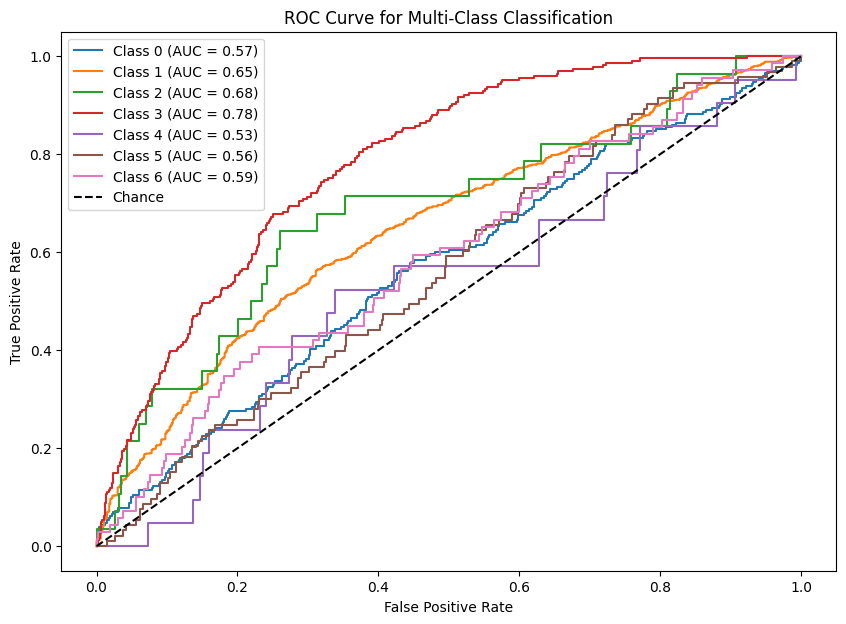

In [133]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert y_test to one-hot encoding
y_test_one_hot = label_binarize(y_test, classes=np.arange(len(label_mapping)))

# Get predicted probabilities
y_pred_proba = model.predict(X_test)

# Plot ROC Curve for each class
plt.figure(figsize=(10, 7))
for i in range(len(label_mapping)):  # Number of classes
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend()
plt.show()


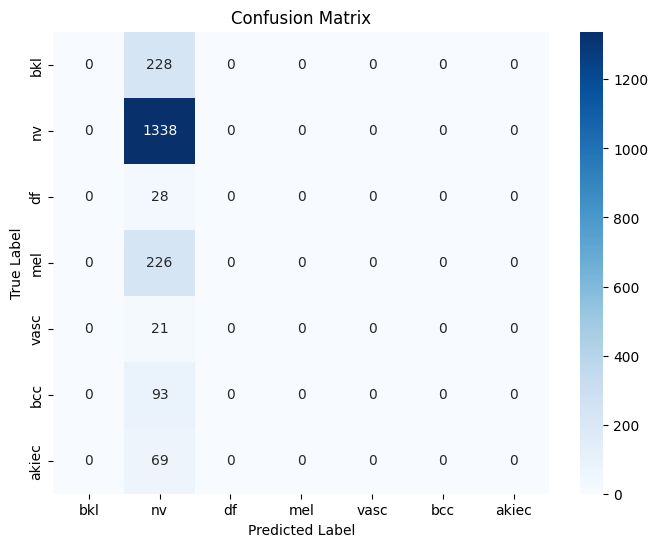

In [134]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [135]:
# ------ Evaluation Metrics -------
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Call the evaluation function for the hybrid model
hybrid_metrics1 = evaluate_model(y_test, y_pred, model_name="Hybrid R-CNN + SSD Model")

# Save the model
model.save('hybrid_rcnn_ssd_skin_lesion_model.h5')

Results for Hybrid R-CNN + SSD Model:
Accuracy: 0.6680
Precision: 0.9526
Recall: 0.1429
F1-score: 0.1144


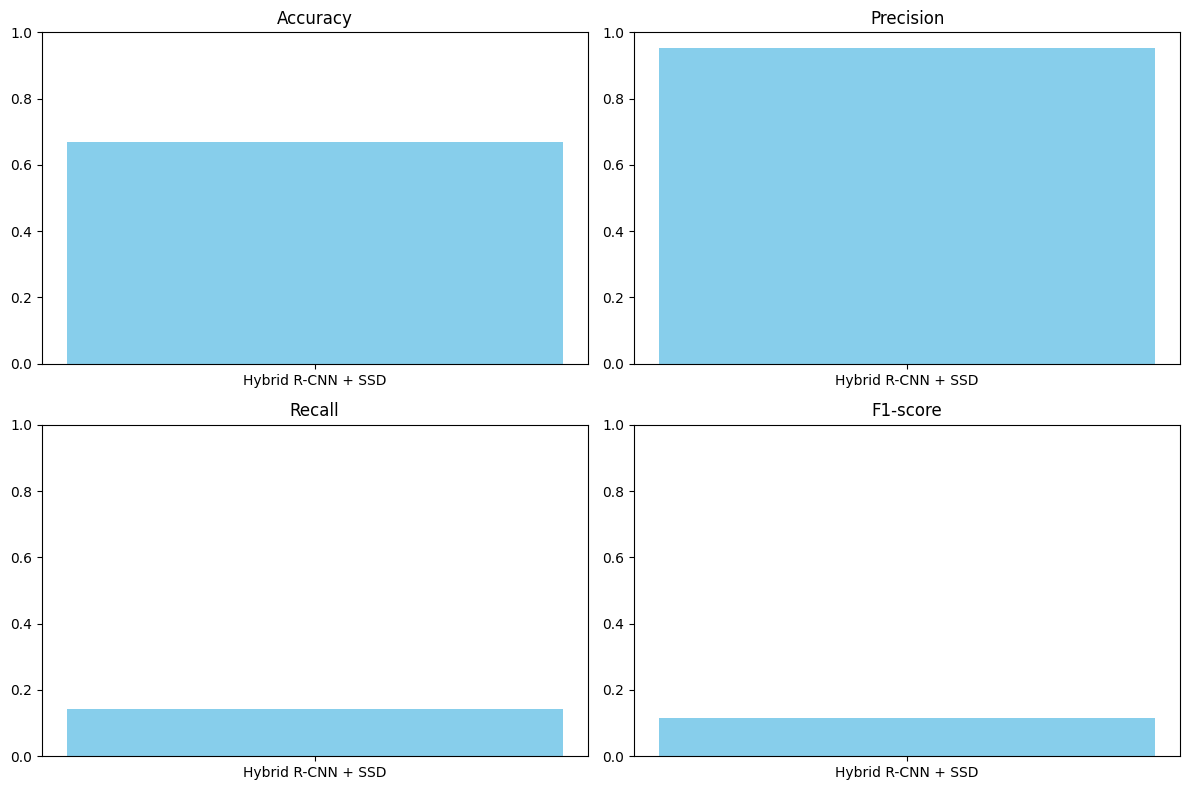

In [136]:
# ------ Plotting Results ------
models = ['Hybrid R-CNN + SSD']
accuracy = [hybrid_metrics1[0]]
precision = [hybrid_metrics1[1]]
recall = [hybrid_metrics1[2]]
f1 = [hybrid_metrics1[3]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

# Create subplots for each metric
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(models, metrics_values[i], color=['skyblue'])
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

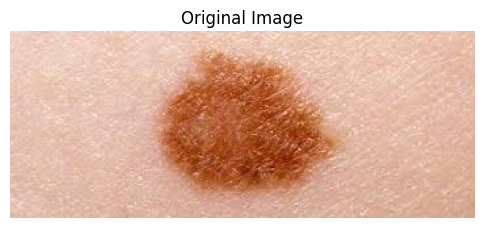

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: 1


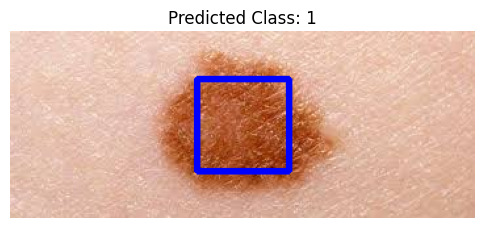

In [137]:
# Function to predict and mark image for the hybrid model
def predict_and_mark_image(image_path, hybrid_model, input_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return
    
    # Show the original image first
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    img_copy = img.copy()
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img / 255.0, axis=0)  # Normalize and expand dimensions

    # Predict using the hybrid model
    prediction = hybrid_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class

    print(f"Predicted class: {predicted_class}")

    # Mark the center of the image with a red square (for demo purposes)
    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 2

    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)

    # Show the image with the red square
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage: Pass the image path and hybrid model
image_path = 'images/images.jpeg'  # Replace with the actual test image path
hybrid_model = tf.keras.models.load_model('hybrid_rcnn_ssd_skin_lesion_model.h5')
predict_and_mark_image(image_path, hybrid_model)

Deep Neural Networks(DNN)

In [73]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [74]:
# Set data paths
IMAGE_PATH = 'images/HAM10000_images'  
LABELS_PATH = 'images/HAM10000_metadata.csv'   

# Load the labels from the metadata file
df = pd.read_csv(LABELS_PATH)

# Create a mapping of labels
label_mapping = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_mapping)

# Load and preprocess images
def load_images(df, image_path, image_size=(128, 128)):
    images = []
    labels = []
    for image_id in df['image_id']:
        img_path = os.path.join(image_path, f"{image_id}.jpg")
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if image is not found
        img = cv2.resize(img, image_size)
        images.append(img)
        labels.append(df.loc[df['image_id'] == image_id, 'label'].values[0])
    return np.array(images), np.array(labels)

# Load and split data
X, y = load_images(df, IMAGE_PATH)
X = X / 255.0  # Normalize images to [0,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [75]:
# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=len(label_mapping))
y_test = to_categorical(y_test, num_classes=len(label_mapping))


In [76]:
# Verify the shapes of y_train and y_test
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


y_train shape: (8012, 7)
y_test shape: (2003, 7)


In [78]:
# Build the DNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and add fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(label_mapping), activation='softmax'))  # Output layer with softmax for multi-class classification

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,942,407 (49.37 MB)

 Trainable params: 12,942,407 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 323ms/step - accuracy: 0.6402 - loss: 1.1379 - val_accuracy: 0.6860 - val_loss: 0.9022
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.6945 - loss: 0.8475 - val_accuracy: 0.6800 - val_loss: 0.8708
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 325ms/step - accuracy: 0.7015 - loss: 0.8073 - val_accuracy: 0.7009 - val_loss: 0.8209
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 84s 333ms/step - accuracy: 0.7274 - loss: 0.7417 - val_accuracy: 0.7174 - val_loss: 0.8113
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 330ms/step - accuracy: 0.7502 - loss: 0.6869 - val_accuracy: 0.7254 - val_loss: 0.7639
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 331ms/step - accuracy: 0.7735 - loss: 0.6226 - val_accuracy: 0.7334 - val_loss: 0.7475
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 91s 362ms/step - accuracy: 0.7813 - loss: 0.5783 - val_accuracy: 0.7349 - val_loss: 0.7493
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 94s 374ms/step - accuracy: 0.8096 - loss: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step


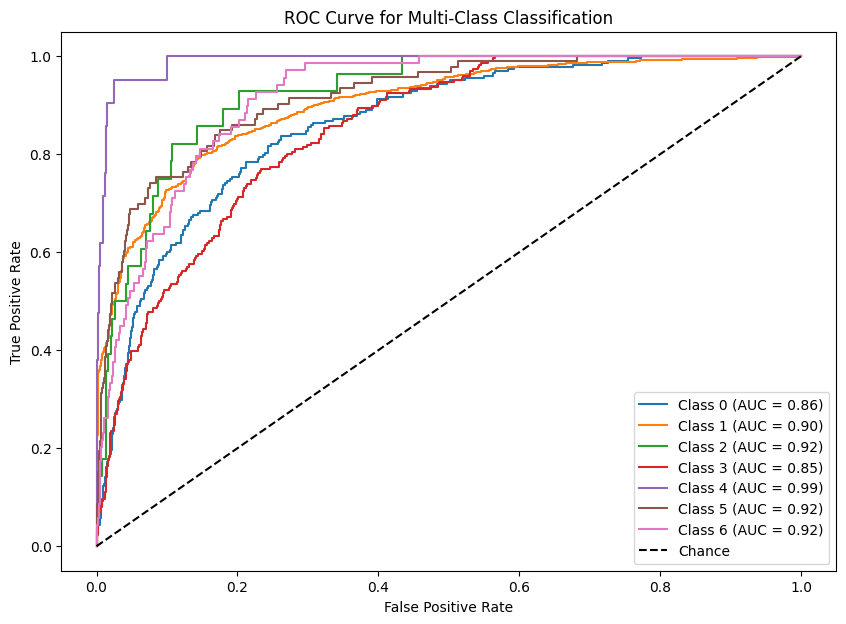

In [80]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding (already done in training)
n_classes = len(label_mapping)

# Get model predictions (probabilities)
y_pred_proba = model.predict(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()


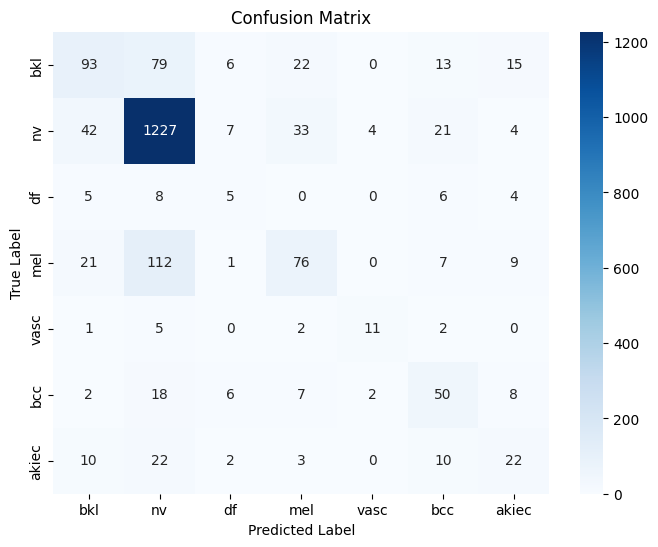

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert one-hot encoded labels back to class labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred_proba, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [82]:
# Save the model
model.save("dnn_skin_lesion_model.h5")
print("Model saved as 'dnn_skin_lesion_model.h5'.")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

# Get predictions for evaluation metrics
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

Model saved as 'dnn_skin_lesion_model.h5'.
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7376 - loss: 0.8116
Test Accuracy: 0.7409
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


In [83]:
# ------ Evaluation Metrics -------
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Evaluate the model using the custom function
dnn_metrics=evaluate_model(y_true, y_pred, "DNN_Skin Lesion Model")
dnn_metrics

Results for DNN_Skin Lesion Model:
Accuracy: 0.7409
Precision: 0.5066
Recall: 0.4600
F1-score: 0.4771


(0.7408886669995007,
 0.5065537213438608,
 0.4600106031600651,
 0.4771320156726427)

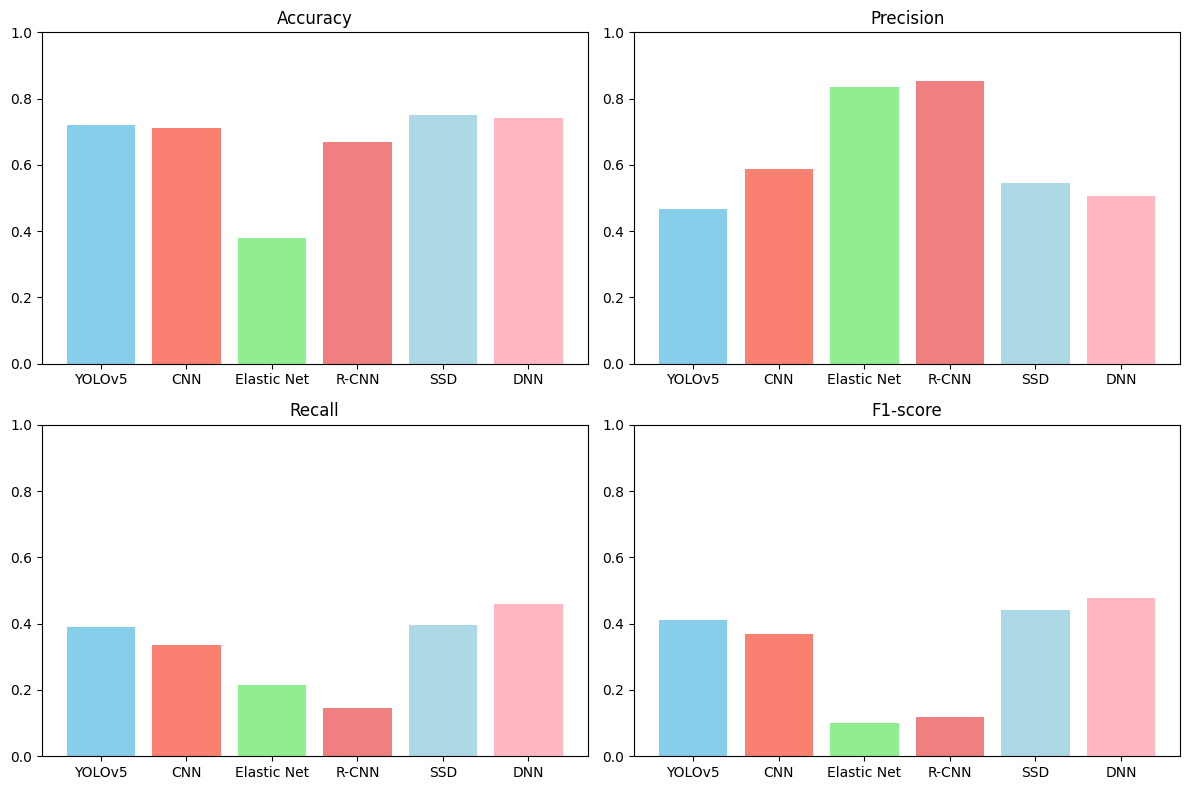

In [84]:
# ------ Plotting Results ------
models = ['YOLOv5', 'CNN', 'Elastic Net', 'R-CNN', 'SSD', 'DNN']
accuracy = [yolo_metrics[0], cnn_metrics[0], elastic_net_metrics[0], rcnn_metrics[0], ssd_metrics[0], dnn_metrics[0]]
precision = [yolo_metrics[1], cnn_metrics[1], elastic_net_metrics[1], rcnn_metrics[1], ssd_metrics[1], dnn_metrics[1]]
recall = [yolo_metrics[2], cnn_metrics[2], elastic_net_metrics[2], rcnn_metrics[2], ssd_metrics[2], dnn_metrics[2]]
f1 = [yolo_metrics[3], cnn_metrics[3], elastic_net_metrics[3], rcnn_metrics[3], ssd_metrics[3], dnn_metrics[3]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

# Create subplots for each metric
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(models, metrics_values[i], color=['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'lightblue', 'lightpink'])
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

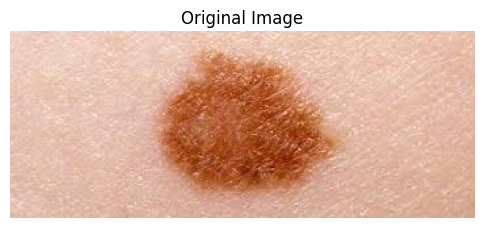

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class: 1


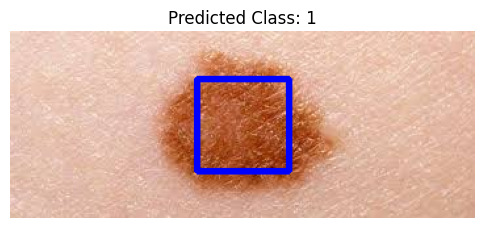

In [85]:
# Define the function to predict and mark the image
from tensorflow.keras.models import load_model
def predict_and_mark_image(image_path, dnn_model, input_size=(128, 128)):
    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return
    
    # Show the original image first
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Make a copy of the image for display
    img_copy = img.copy()

    # Resize the image to match DNN input
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img / 255.0, axis=0)  # Normalize and expand dimensions
    
    # Predict using the DNN model
    prediction = dnn_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class

    # Print the prediction result
    print(f"Predicted class: {predicted_class}")

    # Mark the center of the lesion with a red square (for demo purposes)
    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 2  # Adjust the square size as needed

    # Draw a red square around the center of the image
    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)  # (BGR format)

    # Show the image with the red square
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage: Pass the image path and DNN model
image_path = 'images/images.jpeg'  # Replace with the actual test image path
dnn_model = load_model('dnn_skin_lesion_model.h5')  # Load your trained DNN model
predict_and_mark_image(image_path, dnn_model)

Bayesian neural network (BNN)

In [86]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [87]:
# Set data paths
IMAGE_PATH = 'images/HAM10000_images'
LABELS_PATH = 'images/HAM10000_metadata.csv'

# Load the labels from the metadata file
df = pd.read_csv(LABELS_PATH)

# Create a mapping of labels
label_mapping = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_mapping)

# Load and preprocess images
def load_images(df, image_path, image_size=(128, 128)):
    images = []
    labels = []
    for image_id in df['image_id']:
        img_path = os.path.join(image_path, f"{image_id}.jpg")
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if image is not found
        img = cv2.resize(img, image_size)
        images.append(img)
        labels.append(df.loc[df['image_id'] == image_id, 'label'].values[0])
    return np.array(images), np.array(labels)

# Load and split data
X, y = load_images(df, IMAGE_PATH)
X = X / 255.0  # Normalize images to [0,1]
y = to_categorical(y)  # Convert labels to categorical (one-hot encoding)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
# Define the Bayesian Neural Network Model (BNN)
def build_bnn(input_shape=(128, 128, 3), num_classes=7):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Build the model
model = build_bnn()

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\yogee\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [89]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 58s 223ms/step - accuracy: 0.6495 - loss: 1.4259 - val_accuracy: 0.6605 - val_loss: 0.9503
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.6810 - loss: 0.9068 - val_accuracy: 0.6855 - val_loss: 0.8735
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 217ms/step - accuracy: 0.6951 - loss: 0.8533 - val_accuracy: 0.6870 - val_loss: 0.9540
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 224ms/step - accuracy: 0.7206 - loss: 0.7735 - val_accuracy: 0.7164 - val_loss: 0.8074
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - accuracy: 0.7345 - loss: 0.7221 - val_accuracy: 0.7074 - val_loss: 0.8091
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.7479 - loss: 0.6863 - val_accuracy: 0.7054 - val_loss: 0.8432
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 223ms/step - accuracy: 0.7621 - loss: 0.6403 - val_accuracy: 0.7324 - val_loss: 0.7731
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 222ms/step - accuracy: 0.7908 - loss: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


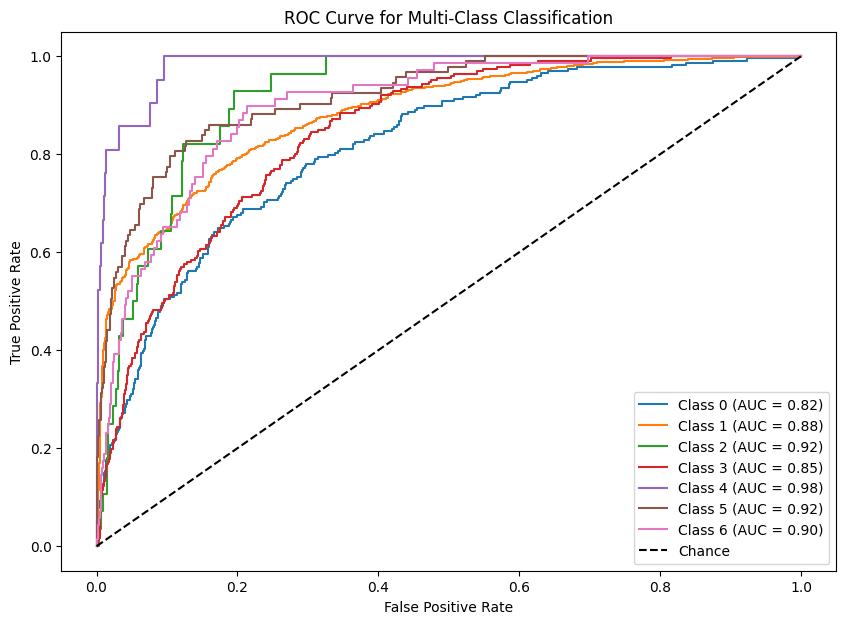

In [91]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert y_test to categorical if not already one-hot encoded
y_test_one_hot = label_binarize(y_test, classes=np.arange(7))  # 7 classes

# Get predicted probabilities from the model
y_pred_proba = model.predict(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(7):  # Loop through each class
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random guess)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


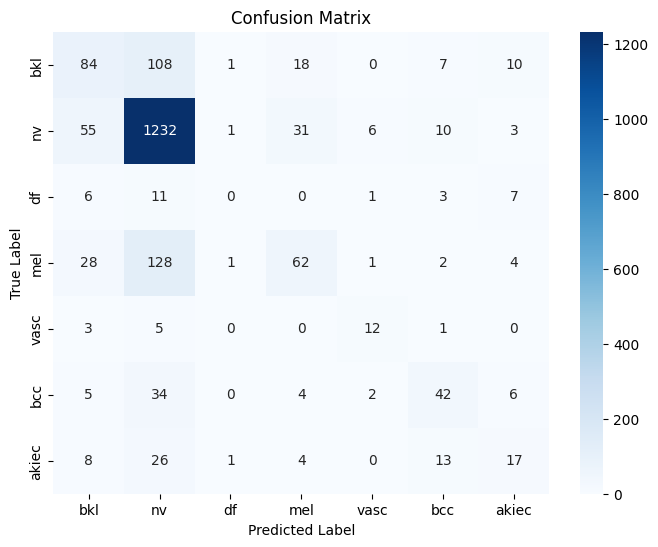

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert one-hot encoded y_test back to class labels
y_test_labels = np.argmax(y_test, axis=1)  # Convert from one-hot to class index

# Get predicted classes
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [94]:
# Save the model
model.save('bnn_skin_lesion_model.h5')
print("Model saved to 'bnn_skin_lesion_model.h5'")

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

Model saved to 'bnn_skin_lesion_model.h5'
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


In [95]:
# ------ Evaluation Metrics -------
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Evaluate the model
bnn_metrics=evaluate_model(y_test_classes, y_pred_classes, "BNN Skin Lesion Detection")

Results for BNN Skin Lesion Detection:
Accuracy: 0.7234
Precision: 0.4584
Recall: 0.4047
F1-score: 0.4228


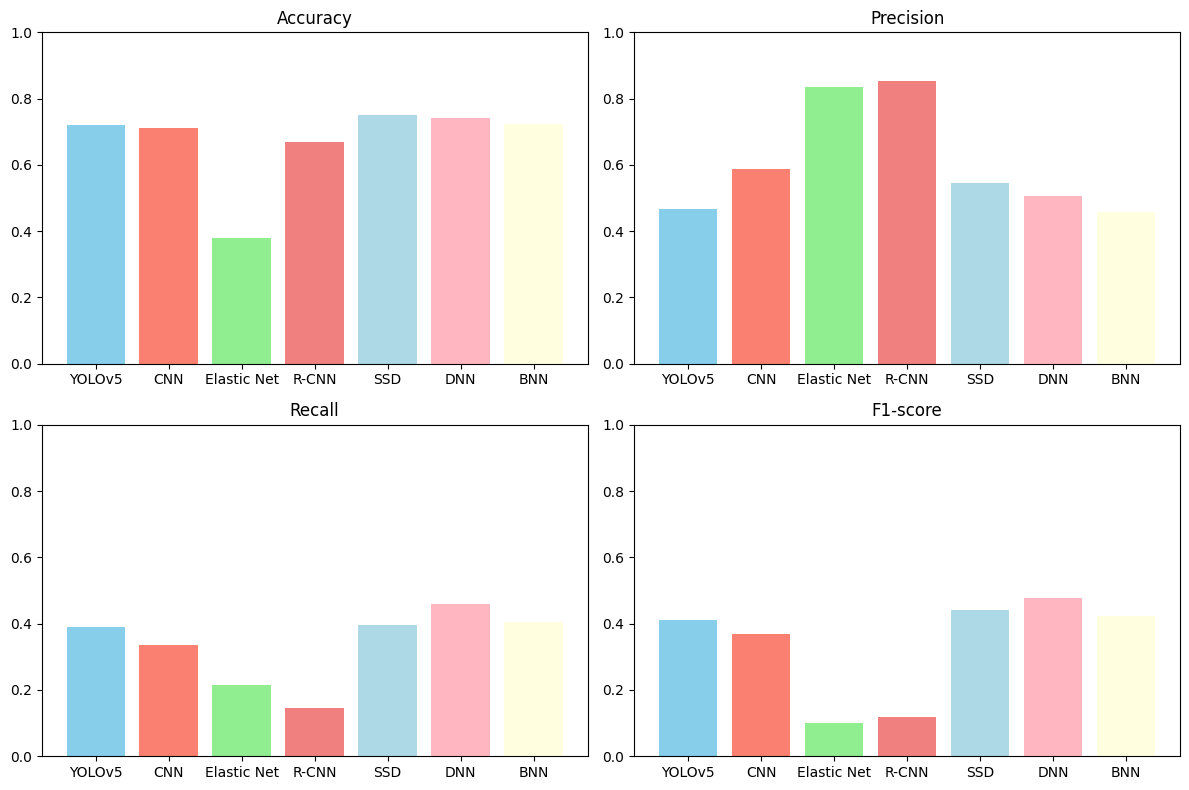

In [96]:
# ------ Plotting Results ------
models = ['YOLOv5', 'CNN', 'Elastic Net', 'R-CNN', 'SSD', 'DNN', 'BNN']
accuracy = [yolo_metrics[0], cnn_metrics[0], elastic_net_metrics[0], rcnn_metrics[0], ssd_metrics[0], dnn_metrics[0], bnn_metrics[0]]
precision = [yolo_metrics[1], cnn_metrics[1], elastic_net_metrics[1], rcnn_metrics[1], ssd_metrics[1], dnn_metrics[1], bnn_metrics[1]]
recall = [yolo_metrics[2], cnn_metrics[2], elastic_net_metrics[2], rcnn_metrics[2], ssd_metrics[2], dnn_metrics[2], bnn_metrics[2]]
f1 = [yolo_metrics[3], cnn_metrics[3], elastic_net_metrics[3], rcnn_metrics[3], ssd_metrics[3], dnn_metrics[3], bnn_metrics[3]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

# Create subplots for each metric
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(models, metrics_values[i], color=['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'lightblue', 'lightpink', 'lightyellow'])
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

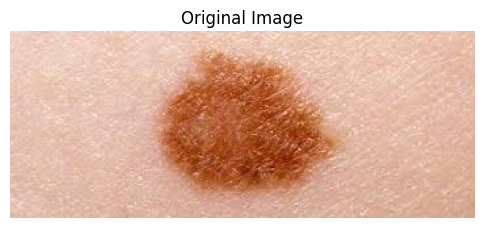

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted class: 1


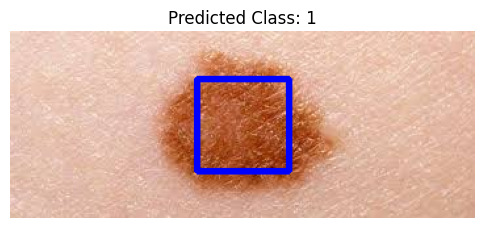

In [97]:
# Define the function to predict and mark the image
from tensorflow.keras.models import load_model
def predict_and_mark_image(image_path, bnn_model, input_size=(128, 128)):
    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return
    
    # Show the original image first
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Make a copy of the image for display
    img_copy = img.copy()

    # Resize the image to match BNN input
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img / 255.0, axis=0)  # Normalize and expand dimensions
    
    # Predict using the BNN model
    prediction = bnn_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class

    # Print the prediction result
    print(f"Predicted class: {predicted_class}")

    # Mark the center of the lesion with a red square (for demo purposes)
    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 2  # Adjust the square size as needed

    # Draw a red square around the center of the image
    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)  # (BGR format)

    # Show the image with the red square
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage: Pass the image path and the pre-trained BNN model
image_path = 'images/images.jpeg'  # Replace with the actual test image path
bnn_model = load_model('bnn_skin_lesion_model.h5')  # Load the pre-trained BNN model
predict_and_mark_image(image_path, bnn_model)

DNN_BNN HYBRID

In [98]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [99]:
# Set data paths
IMAGE_PATH = 'images/HAM10000_images'
LABELS_PATH = 'images/HAM10000_metadata.csv'

# Load the labels from the metadata file
df = pd.read_csv(LABELS_PATH)

# Create a mapping of labels
label_mapping = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_mapping)

# Load and preprocess images
def load_images(df, image_path, image_size=(128, 128)):
    images = []
    labels = []
    for image_id in df['image_id']:
        img_path = os.path.join(image_path, f"{image_id}.jpg")
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if image is not found
        img = cv2.resize(img, image_size)
        images.append(img)
        labels.append(df.loc[df['image_id'] == image_id, 'label'].values[0])
    return np.array(images), np.array(labels)

# Load and split data
X, y = load_images(df, IMAGE_PATH)
X = X / 255.0  # Normalize images to [0,1]
y = to_categorical(y)  # Convert labels to categorical (one-hot encoding)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [100]:
# ------ DNN Model ------
def build_dnn(input_shape=(128, 128, 3), num_classes=7):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [101]:
# ------ BNN Model ------
def build_bnn(input_shape=(128, 128, 3), num_classes=7):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [102]:
# ------ Hybrid Model ------
def build_hybrid_model(input_shape=(128, 128, 3), num_classes=7):
    dnn_model = build_dnn(input_shape, num_classes)
    bnn_model = build_bnn(input_shape, num_classes)

    # Inputs
    input_layer = Input(shape=input_shape)

    # DNN and BNN Outputs
    dnn_output = dnn_model(input_layer)
    bnn_output = bnn_model(input_layer)

    # Merge DNN and BNN outputs
    merged_output = layers.Add()([dnn_output, bnn_output])

    # Final layer (Softmax)
    final_output = Dense(num_classes, activation='softmax')(merged_output)

    # Create hybrid model
    hybrid_model = Model(inputs=input_layer, outputs=final_output)
    return hybrid_model

# Build the hybrid model
model = build_hybrid_model()

# Compile the hybrid model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\yogee\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [103]:
# Train the hybrid model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 134s 522ms/step - accuracy: 0.6656 - loss: 1.3093 - val_accuracy: 0.6680 - val_loss: 1.1716
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 510ms/step - accuracy: 0.6682 - loss: 1.1598 - val_accuracy: 0.6680 - val_loss: 1.1410
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 527ms/step - accuracy: 0.6695 - loss: 1.1442 - val_accuracy: 0.6680 - val_loss: 1.1337
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 134s 535ms/step - accuracy: 0.6665 - loss: 1.1352 - val_accuracy: 0.6680 - val_loss: 1.1318
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 524ms/step - accuracy: 0.6629 - loss: 1.1543 - val_accuracy: 0.6680 - val_loss: 1.1311
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 552ms/step - accuracy: 0.6794 - loss: 1.1087 - val_accuracy: 0.6680 - val_loss: 1.1308
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 565ms/step - accuracy: 0.6705 - loss: 1.1324 - val_accuracy: 0.6680 - val_loss: 1.1309
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 125s 498ms/step - accuracy: 0.6679 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step 


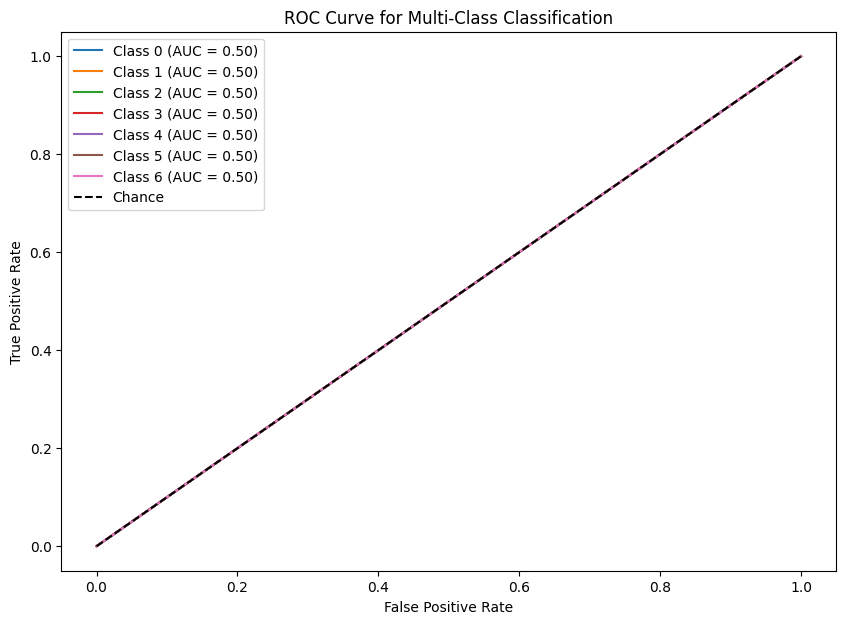

In [104]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Get predicted probabilities
y_pred_proba = model.predict(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 7))
for i in range(7):  # 7 classes in HAM10000 dataset
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random guessing)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()


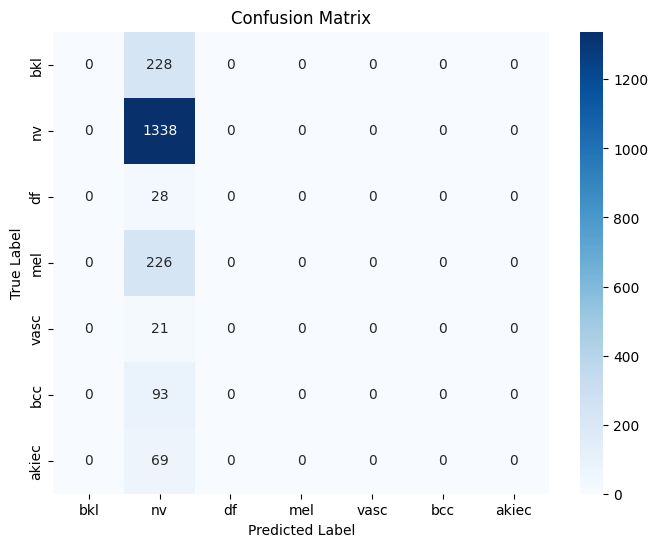

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted class labels
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [106]:
# Save the hybrid model
model.save('dnn_bnn_hybrid_model.h5')
print("Hybrid model saved to 'dnn_bnn_hybrid_model.h5'")

Hybrid model saved to 'dnn_bnn_hybrid_model.h5'


In [107]:
# Evaluate the hybrid model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step 


In [108]:
# ------ Evaluation Metrics -------
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Evaluate the hybrid model
hybridbnndnn_metrics = evaluate_model(y_test_classes, y_pred_classes, "Hybrid DNN + BNN Skin Lesion Detection")


Results for Hybrid DNN + BNN Skin Lesion Detection:
Accuracy: 0.6680
Precision: 0.9526
Recall: 0.1429
F1-score: 0.1144


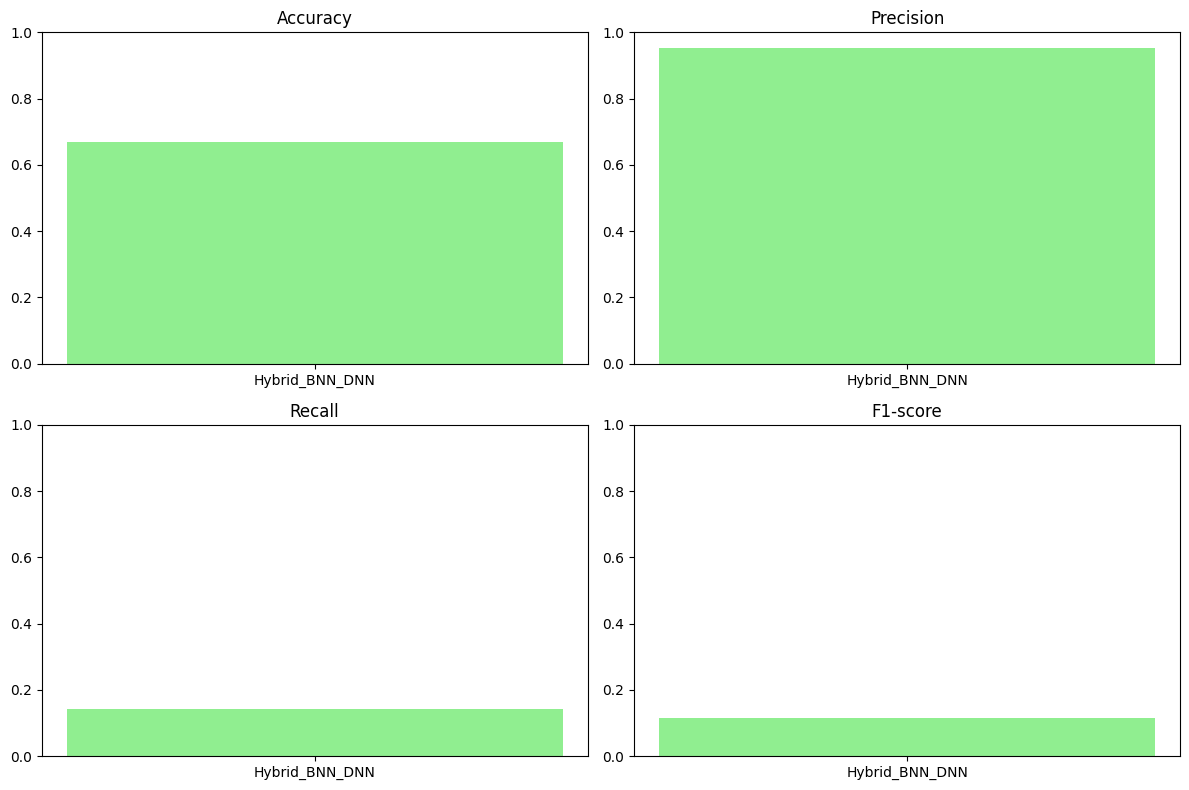

In [109]:
# ------ Plotting Results ------
models = ['Hybrid_BNN_DNN']
accuracy = [hybridbnndnn_metrics[0]]
precision = [hybridbnndnn_metrics[1]]
recall = [hybridbnndnn_metrics[2]]
f1 = [hybridbnndnn_metrics[3]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

# Create subplots for each metric
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(models, metrics_values[i], color=['lightgreen'])
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()


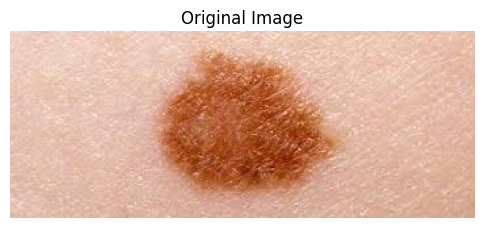

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Predicted class: 1


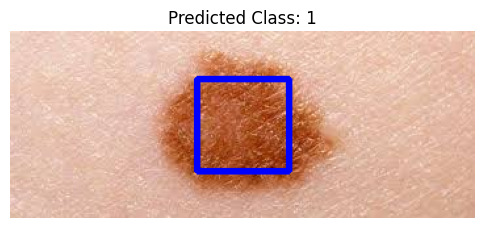

In [110]:
# Define the function to predict and mark the image
def predict_and_mark_image(image_path, hybrid_model, input_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    img_copy = img.copy()
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img / 255.0, axis=0)  # Normalize and expand dimensions
    
    prediction = hybrid_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class

    print(f"Predicted class: {predicted_class}")

    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 2

    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'images/images.jpeg'  # Replace with the actual test image path
hybrid_model = load_model('dnn_bnn_hybrid_model.h5')  # Load the pre-trained hybrid model
predict_and_mark_image(image_path, hybrid_model)

Hybrid Model Comparisons 

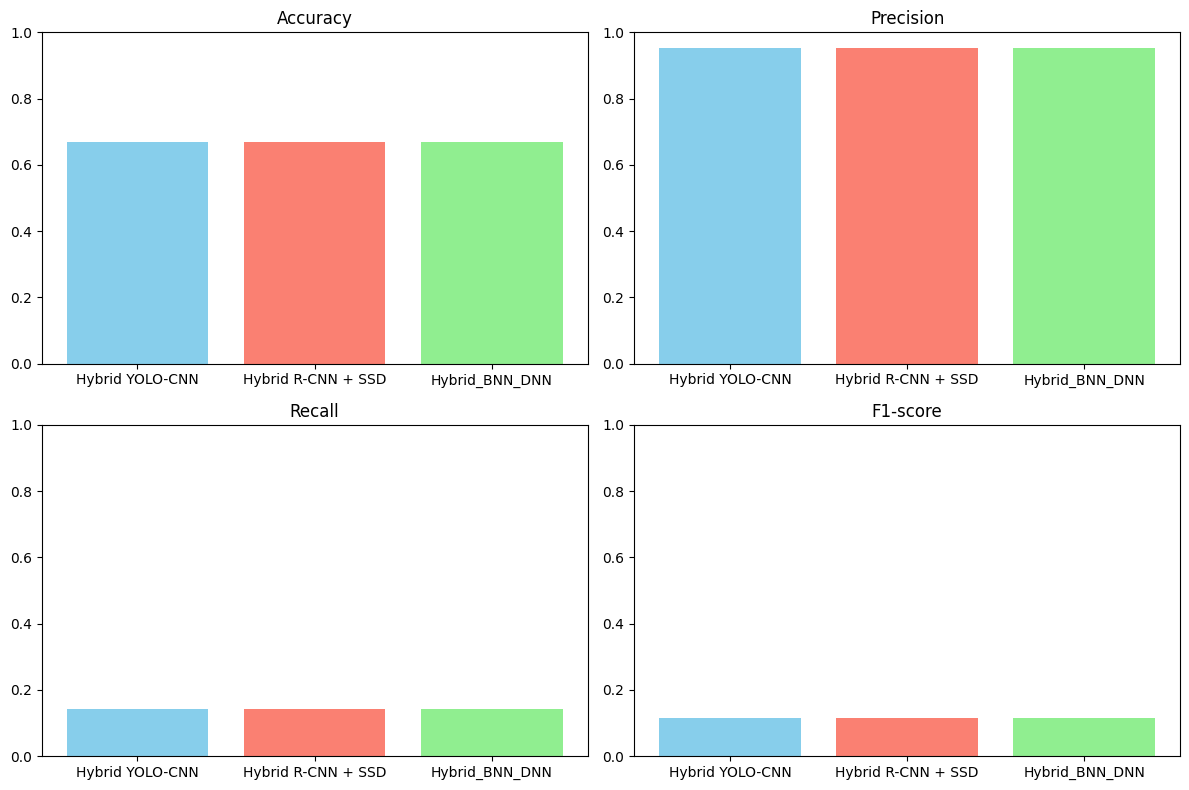

In [139]:
# ------ Plotting Results ------
models = ['Hybrid YOLO-CNN', 'Hybrid R-CNN + SSD', 'Hybrid_BNN_DNN']
accuracy = [hybrid_metrics[0], hybrid_metrics1[0], hybridbnndnn_metrics[0]]
precision = [hybrid_metrics[1], hybrid_metrics1[1], hybridbnndnn_metrics[1]]
recall = [hybrid_metrics[2], hybrid_metrics1[2], hybridbnndnn_metrics[2]]
f1 = [hybrid_metrics[3], hybrid_metrics1[3], hybridbnndnn_metrics[3]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [accuracy, precision, recall, f1]

# Create subplots for each metric
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(models, metrics_values[i], color=['skyblue', 'salmon', 'lightgreen'])
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Ensemble Learning Model

In [111]:
import torch
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, MobileNetV2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [112]:
# ------ Hybrid YOLO-CNN Model Implementation ------- (PyTorch)
class HybridYOLOCNN(nn.Module):
    def __init__(self):
        super(HybridYOLOCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 7)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.reshape(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ------ Hybrid R-CNN + SSD Model Implementation ------- (TensorFlow)
def hybrid_rcnn_ssd_model(input_shape=(128, 128, 3), num_classes=7):
    input_layer = Input(shape=input_shape)
    
    # R-CNN using ResNet50
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_resnet.trainable = False
    x = base_model_resnet(input_layer)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    region_proposal_layer = Dense(num_classes, activation='softmax')(x)
    
    # SSD using MobileNetV2
    base_model_mobilenet = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model_mobilenet.trainable = False
    y = base_model_mobilenet(input_layer)
    y = Conv2D(512, (3, 3), activation='relu', padding='same')(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Flatten()(y)
    y = Dense(256, activation='relu')(y)
    y = Dropout(0.5)(y)
    ssd_output_layer = Dense(num_classes, activation='softmax')(y)
    
    # Combine R-CNN and SSD outputs
    final_output = Add()([region_proposal_layer, ssd_output_layer])
    
    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ------ Hybrid DNN + BNN Model Implementation ------- (TensorFlow)
def build_dnn(input_shape=(128, 128, 3), num_classes=7):
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_bnn(input_shape=(128, 128, 3), num_classes=7):
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_hybrid_model(input_shape=(128, 128, 3), num_classes=7):
    dnn_model = build_dnn(input_shape, num_classes)
    bnn_model = build_bnn(input_shape, num_classes)

    input_layer = Input(shape=input_shape)
    dnn_output = dnn_model(input_layer)
    bnn_output = bnn_model(input_layer)

    merged_output = Add()([dnn_output, bnn_output])
    final_output = Dense(num_classes, activation='softmax')(merged_output)

    hybrid_model = Model(inputs=input_layer, outputs=final_output)
    return hybrid_model


In [118]:
# ------ Ensemble Model ------
def ensemble_model(models, input_shape=(128, 128, 3), num_classes=7):
    input_layer = Input(shape=input_shape)
    
    model_outputs = []
    for model in models:
        model_output = model(input_layer)
        model_outputs.append(model_output)
    
    final_output = Add()(model_outputs)
    final_model = Model(inputs=input_layer, outputs=final_output)
    final_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return final_model


In [113]:
# ------ Ensemble Model ------- (TensorFlow)
def ensemble_model(models, input_shape=(128, 128, 3), num_classes=7):
    input_layer = Input(shape=input_shape)
    
    model_outputs = []
    for model in models:
        model_output = model(input_layer)
        model_outputs.append(model_output)
    
    final_output = Add()(model_outputs)
    final_model = Model(inputs=input_layer, outputs=final_output)
    final_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return final_model

# Initialize all models
yolo_cnn_model = HybridYOLOCNN()  # PyTorch model (no need to run in TensorFlow)
rcnn_ssd_model = hybrid_rcnn_ssd_model()  # TensorFlow model
dnn_bnn_model = build_hybrid_model()  # TensorFlow model

C:\Users\yogee\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [114]:
# Ensemble of all three models
ensemble = ensemble_model([rcnn_ssd_model, dnn_bnn_model])  # Excluding the PyTorch model

# Ensure that the models are fully built before training
ensemble.summary()


Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_78 (Functional)    │ (None, 7)                 │      34,376,142 │ input_layer_19[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_81 (Functional)    │ (None, 7)                 │      20,335,686 │ input_layer_19[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 7)                 │               0 │ functional_78[0][0],       │
│                               │                           │                 │ functional_81[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 54,711,828 (208.71 MB)

 Trainable params: 28,866,132 (110.12 MB)

 Non-trainable params: 25,845,696 (98.59 MB)

In [115]:
# Train the ensemble model
ensemble.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.6563 - loss: 1.2146 - val_accuracy: 0.6680 - val_loss: 1.1576
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.6739 - loss: 1.1382 - val_accuracy: 0.6680 - val_loss: 1.1311
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.6582 - loss: 1.1576 - val_accuracy: 0.6680 - val_loss: 1.1214
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.6775 - loss: 1.1100 - val_accuracy: 0.6680 - val_loss: 1.1169
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.6713 - loss: 1.1162 - val_accuracy: 0.6680 - val_loss: 1.1280
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.6729 - loss: 1.1104 - val_accuracy: 0.6680 - val_loss: 1.1115
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.6709 - loss: 1.1182 - val_accuracy: 0.6680 - val_loss: 1.1064
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.6694 - loss: 1.1100 - val_accu

In [116]:
# Evaluate the ensemble model
y_pred = ensemble.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 914ms/step


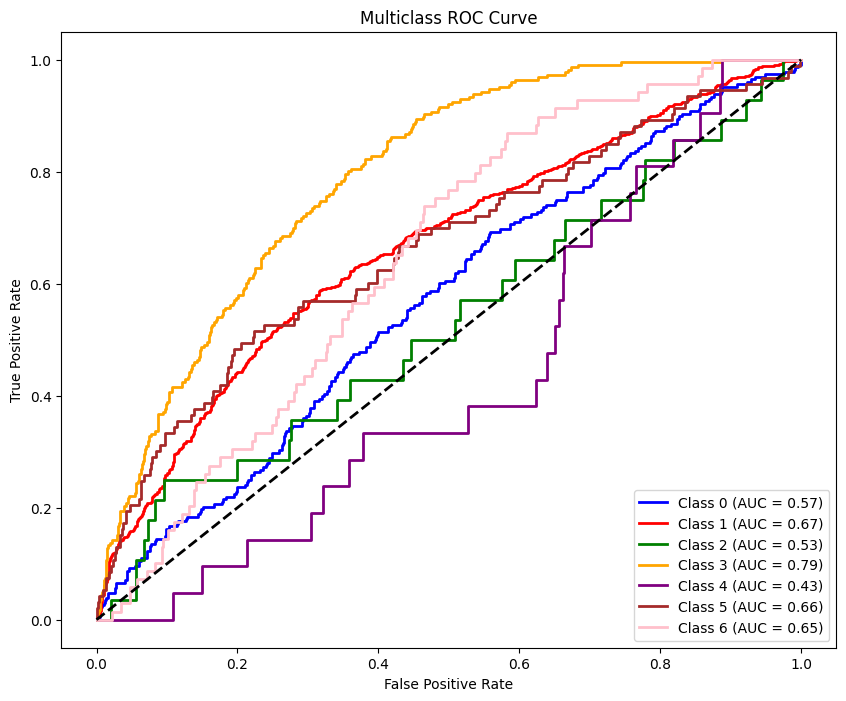

In [118]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC Curve (One-vs-Rest strategy)
n_classes = y_test.shape[1]  # Number of classes
y_test_bin = y_test  # Already one-hot encoded
y_pred_bin = y_pred  # Model outputs probability scores

# Colors for each class
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 956ms/step


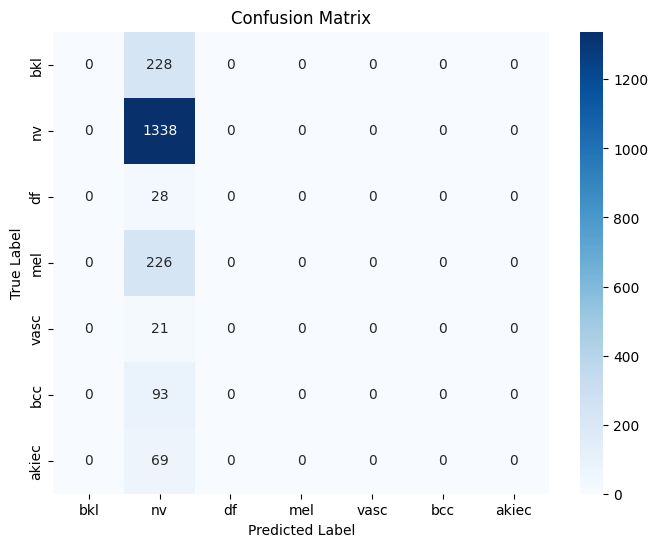

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions (convert probabilities to class labels)
y_pred = ensemble.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class indices
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [136]:
ensemble.save('ensemble_model.h5')
print("Model saved as 'ensemble_model.h5'.")


Model saved as 'ensemble_model.h5'.


Results for Ensemble Model:
Accuracy: 0.6680
Precision: 0.9526
Recall: 0.1429
F1-score: 0.1144


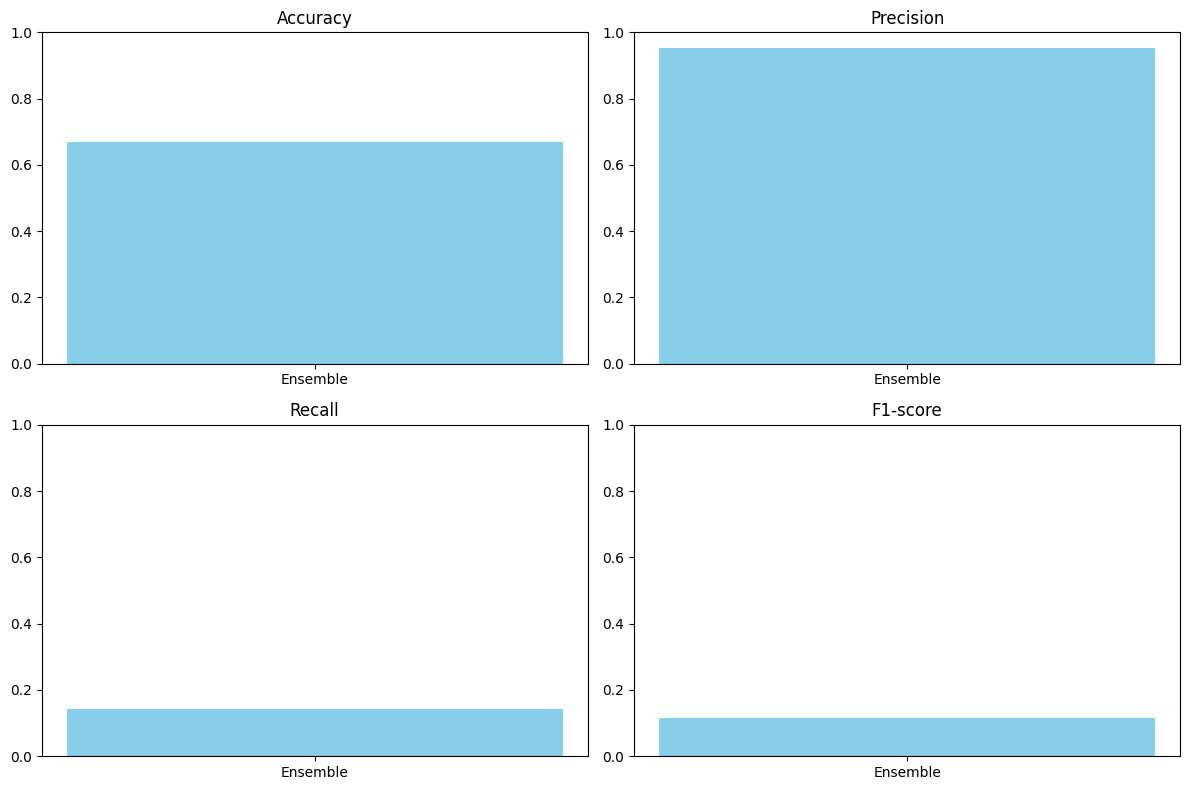

In [137]:
# Evaluate the model
ensemble_metrics = evaluate_model(y_test_classes, y_pred_classes, "Ensemble Model")

# Plot evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [ensemble_metrics[0], ensemble_metrics[1], ensemble_metrics[2], ensemble_metrics[3]]

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(['Ensemble'], metrics_values[i], color=['skyblue'])
    plt.title(metric)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Model loaded successfully from ensemble_model.h5


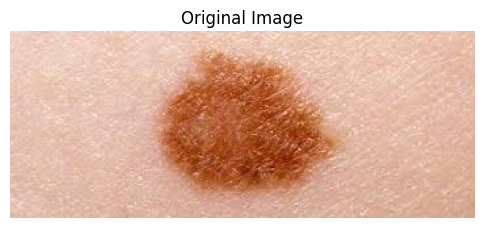

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: 1


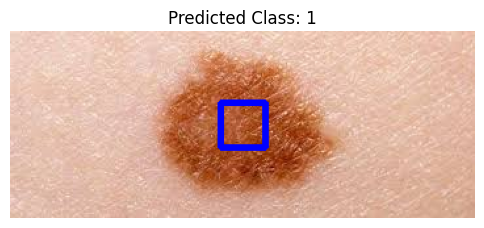

In [138]:
# Define the function to predict and mark the image
def load_saved_model(model_path):

    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def predict_and_mark_image(image_path, ensemble_model, input_size=(128, 128)):

    # Read the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image {image_path} not found.")
        return

    # Show the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Create a copy of the image for marking
    img_copy = img.copy()

    # Resize the image to match the input size of the ensemble model
    resized_img = cv2.resize(img, input_size)
    img_array = np.expand_dims(resized_img / 255.0, axis=0)  # Normalize and expand dimensions

    # Predict using the ensemble model
    prediction = ensemble_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class

    # Print the prediction result
    print(f"Predicted class: {predicted_class}")

    # Mark the center of the image with a rectangle
    height, width, _ = img.shape
    center_x, center_y = width // 2, height // 2
    square_size = min(width, height) // 4  # Adjust the square size as needed

    # Draw a rectangle at the center of the image
    top_left = (center_x - square_size // 2, center_y - square_size // 2)
    bottom_right = (center_x + square_size // 2, center_y + square_size // 2)
    marked_img = cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 4)  # Red rectangle (BGR format)

    # Display the marked image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example Usage
model_path = "ensemble_model.h5"  # Replace with the path to your saved model
ensemble_model = load_saved_model(model_path)

if ensemble_model:
    image_path = 'images/images.jpeg'  # Replace with the actual test image path
    predict_and_mark_image(image_path, ensemble_model)